In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_erp/')
sys.path.append('/usr0/home/drschwar/src/subplot_artist')
import json
import dataclasses
from collections import OrderedDict
from functools import partial

from tqdm import trange, tqdm

import numpy as np
from scipy.stats import ttest_rel

from bert_erp_paths import Paths
from bert_erp_datasets import get_indices_from_normalized_coordinates, get_mask_for_subject
from run_variations import named_variations, task_hash
from bert_erp_settings import TrainingVariation, LoadFrom
from analysis import print_variation_results, sentence_predictions, read_variation_results, print_variation_results_sliced, \
    text_heat_map_html, k_vs_k, loss_curves_for_variation, average_unique_steps_within_loss_curves, \
    average_unique_epochs_within_loss_curves, query_results, ResultQuery, print_min_max, min_max_per_group, \
    remove_hp_fmri_prefix, two_sample_permutation_test, one_sample_permutation_test, Aggregator, sample_differences, \
    wilcoxon_axis, bhy_multiple_comparisons_procedure
from bert_visualization import keyed_colors, bar_eval_key, make_label, bar_grouped, make_bar_group, DisplayName, \
    bar_group_best_for_eval
from result_output import read_predictions
from occlusion import run_occlusion, read_occlusion_predictions, occlusion_sensitivity, sensitivity_delta_mse
%matplotlib inline
from subplot_artist import SubplotArtist, ColorbarArtist, render_subplot_artists, matshow

import cortex

def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    if subject in ['H', 'K', 'L']:
        xfmname = '{}_ars_auto2'.format(subject)
    else:
        xfmname = '{}_ars'.format(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), xfmname, mask=mask, **kwargs)

key_to_color = keyed_colors(('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp'))

display_name = DisplayName({
    ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600'): 'all erp'})

make_label_fn = partial(make_label, display_name)

paths = Paths()

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
result_queries = list()
#subjects = ['I']
subjects = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    #result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    #result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['acc']:  # ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_fmri_diff_cluster', 
            'hp_fmri_diff_cluster', 
            tuple('hp_fmri_{}'.format(s) for s in subjects), 
            tuple('hp_fmri_{}'.format(s) for s in subjects),
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            # vmin = max(0, vmin)
            vmin = np.nanquantile(data, 0.8)
        else:
            # vmin = max(0.5, vmin)
            vmin = np.nanquantile(data, 0.8)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), F, acc, min: 0.3588, max: 0.6444
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), G, acc, min: 0.3914, max: 0.6282
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), H, acc, min: 0.385, max: 0.6254
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), I, acc, min: 0.3718, max: 0.6688
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), J, acc, min: 0.366, max: 0.6472
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), K, acc, min: 0.3514, max: 0.6066
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), L, acc, min: 0.3636, max: 0.636
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), M, acc, min: 0.36, max: 0.6768
hp_fmri_diff_cluster, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'), N, acc, min: 0.3642, max: 0.6184


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Started server on port 48250


<WebApp(Thread-4, started 139652750845696)>

In [2]:
variation = 'hp_fmri_diff'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
eval_first = OrderedDict()
for training_variation in training_variations:
    print_variation_results(paths, variation, training_variation, aux_loss, num_runs)

/usr0/home/drschwar/src/bert_erp/analysis.py:473: RuntimeWarning: Mean of empty slice
  cross_entropy = np.nanmean(cross_entropy, axis=0)
/usr0/home/drschwar/src/bert_erp/analysis.py:473: RuntimeWarning: Mean of empty slice
  cross_entropy = np.nanmean(cross_entropy, axis=0)


(87, 53535) 0
(87, 53535) 0
(87, 53535) 0
(87, 53535) 0
Variation (4 of 4 runs found): hp_fmri_I
  name         xent     acc    macc    poma    prec     rec      f1  
  hp_fmri_I    0.60    0.70    0.70     inf    0.65    0.92    0.75  




In [4]:
from scipy.stats import wilcoxon
result_queries = list()
subjects = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

def match_variation(variation_set_name, training_variation):
    training_variations, _, _, _, _ = named_variations(variation_set_name)
    if isinstance(training_variation, str):
        training_variation_name = training_variation
    elif isinstance(training_variation, TrainingVariation):
        training_variation_name = training_variation.name
    else:
        training_variation_name = str(tuple(training_variation))
    for t in training_variations:
        t_name = t.name if isinstance(t, TrainingVariation) else str(tuple(t))
        if training_variation_name == t_name:
            return t
    raise ValueError('Unable to match training_variation: {}'.format(training_variation))
    

def get_predictions(variation_set_name, training_variation, field_name):
    _, _, num_runs, _, _ = named_variations(variation_set_name)
    training_variation = match_variation(variation_set_name, training_variation)
    print(variation_set_name, training_variation)
    output_dir = os.path.join(paths.result_path, variation_set_name, task_hash(training_variation))
    for index_run in range(num_runs):
        validation_npz_path = os.path.join(output_dir, 'run_{}'.format(index_run), 'output_validation.npz')
        if not os.path.exists(validation_npz_path):
            raise ValueError('Path does not exist: {}'.format(validation_npz_path))
        output_results = read_predictions(validation_npz_path)
        field_results = output_results[field_name]
        aggregator = Aggregator()
        for result in field_results:
            aggregator.update(result, is_sequence=result.sequence_type != 'single')
    
    target = np.array(aggregator.values('target'))
    predictions = np.array(aggregator.values('prediction'))
    mask = np.array(aggregator.values('mask'))
    ids = np.array(aggregator.values('unique_id'))
    masked_target = np.where(mask, target, np.nan)
    return predictions, masked_target, ids


def pove_threshold(values_a, values_b, fdr=0.05):
    candidates = np.reshape(np.arange(1, step=.001), (-1, 1))
    values_a = np.reshape(values_a, (1, -1))
    values_b = np.reshape(values_b, (1, -1))
    count_false = np.count_nonzero(values_a <= -candidates, axis=1) + np.count_nonzero(values_b <= -candidates, axis=1)
    count_all = np.count_nonzero(values_a >= candidates, axis=1) + np.count_nonzero(values_b >= candidates, axis=1)
    fdr_estimates = np.where(count_all > 0, np.divide(count_false, count_all, where=count_all > 0), 1.)
    candidates = candidates[fdr_estimates < fdr]
    if len(candidates) == 0:
        raise ValueError('No threshold meets criteria')
    return candidates[0]


def paired_squared_error(
        variation_set_name_a, training_variation_a, variation_set_name_b, training_variation_b, field_name, num_contiguous):
    predictions_a, target_a, ids_a = get_predictions(variation_set_name_a, training_variation_a, field_name)
    predictions_b, target_b, ids_b = get_predictions(variation_set_name_b, training_variation_b, field_name)
    def _sort(p, t, i):
        sort_order = np.argsort(i)
        return p[sort_order], t[sort_order], i[sort_order]
    predictions_a, target_a, ids_a = _sort(predictions_a, target_a, ids_a)
    predictions_b, target_b, ids_b = _sort(predictions_b, target_b, ids_b)
    
    err_a = np.square(predictions_a - target_a)
    err_b = np.square(predictions_b - target_b)
    
    if not np.array_equal(ids_a, ids_b):
        raise ValueError('Mismatched example ids')
    def _mean_contiguous(e):
        return np.array(list(np.nanmean(item, axis=0) for item in np.array_split(e, int(np.ceil(len(e) / num_contiguous)))))
    mse_a = np.nanmean(err_a, axis=0)
    mse_b = np.nanmean(err_b, axis=0)
    pove_a = 1 - mse_a / np.nanvar(target_a, axis=0)
    pove_b = 1 - mse_b / np.nanvar(target_b, axis=0)
    err_a = _mean_contiguous(err_a)
    err_b = _mean_contiguous(err_b)
    return err_a - err_b, pove_a, pove_b


def read_results(variation_set_name, training_variation, field_name, index_run):
    output_dir = os.path.join(paths.result_path, variation_set_name, task_hash(training_variation))
    validation_npz_path = os.path.join(output_dir, 'run_{}'.format(index_run), 'output_validation.npz')
    if not os.path.exists(validation_npz_path):
        raise ValueError('Path does not exist: {}'.format(validation_npz_path))
    output_results = read_predictions(validation_npz_path)
    field_results = output_results[field_name]
    aggregator = Aggregator()
    for result in field_results:
        aggregator.update(result, is_sequence=result.sequence_type != 'single')
    target = np.array(aggregator.values('target'))
    predictions = np.array(aggregator.values('prediction'))
    ids = np.array(aggregator.values('unique_id'))
    sort_order = np.argsort(ids)
    return predictions[sort_order], target[sort_order]


def k_vs_k_accuracy(predictions, target, indices_true, indices_distractor):
    sample_target = target[indices_true]
    sample_distractor = predictions[indices_distractor]
    sample_predictions = predictions[indices_true]
    
    sample_target = np.reshape(sample_target, (-1, sample_target.shape[-1]))
    sample_distractor = np.reshape(sample_distractor, (-1, sample_distractor.shape[-1]))
    sample_predictions = np.reshape(sample_predictions, (-1, sample_predictions.shape[-1]))
    
    distance_correct = np.sum((sample_target - sample_predictions) ** 2, axis=0)
    distance_incorrect = np.sum((sample_target - sample_distractor) ** 2, axis=0)
    return (distance_incorrect > distance_correct) * 1.0 + (distance_incorrect == distance_correct) * 0.5



class PermutationTestResult:
    def __init__(self, true_values, permutation_values, p_values):
        self.true_values = true_values
        self.permutation_values = permutation_values
        self.p_values = p_values


def paired_k_vs_k_permutation(
    variation_set_name_a, training_variation_a, variation_set_name_b, training_variation_b, field_name, 
        k=20, num_k_vs_k_samples=100, num_permutations=1000):
    _, _, num_runs_a, _, _ = named_variations(variation_set_name_a)
    _, _, num_runs_b, _, _ = named_variations(variation_set_name_b)
    assert(num_runs_a == num_runs_b)
    training_variation_a = match_variation(variation_set_name_a, training_variation_a)
    training_variation_b = match_variation(variation_set_name_b, training_variation_b)
    
    results_a = list()
    results_b = list()
    results_sum = list()
    results_diff = list()
    
    def block_permute_indices(count, block_size):
        permute_indices = np.random.permutation(int(np.ceil(count / block_size)))
        permute_indices = np.reshape(permute_indices * block_size, (-1, 1)) + np.reshape(np.arange(block_size), (1, -1))
        permute_indices = np.reshape(permute_indices, -1)
        return permute_indices[permute_indices < count]
    
    for index_run in range(num_runs_a):
        
        predictions_a, target_a = read_results(variation_set_name_a, training_variation_a, field_name, index_run)
        predictions_b, target_b = read_results(variation_set_name_b, training_variation_b, field_name, index_run)
        assert(len(target_a) == len(target_b))
        
        for index_permutation in trange(num_permutations + 1):
            
            if index_permutation == 0:
                permuted_target_a = target_a
                permuted_target_b = target_b
            else:
                # permute in blocks of 10
                permute_indices = block_permute_indices(len(target_a), block_size=10)
                permuted_target_a = target_a[permute_indices]
                permuted_target_b = target_b[permute_indices]
                
            for index_k_vs_k_sample in range(num_k_vs_k_samples):
                if index_k_vs_k_sample == 0:
                    accuracy_a = np.full((num_k_vs_k_samples, target_a.shape[-1]), np.nan)
                    accuracy_b = np.full((num_k_vs_k_samples, target_b.shape[-1]), np.nan)
                indices_true = np.random.choice(len(target_a), k)
                indices_distractor = np.random.choice(len(target_a), k)
                accuracy_a[index_k_vs_k_sample] = k_vs_k_accuracy(
                    predictions_a, permuted_target_a, indices_true, indices_distractor)
                accuracy_b[index_k_vs_k_sample] = k_vs_k_accuracy(
                    predictions_b, permuted_target_b, indices_true, indices_distractor)
            
            mean_a = np.mean(accuracy_a, axis=0)
            mean_b = np.mean(accuracy_b, axis=0)
            
            for vals, results in [
                    (mean_a, results_a), 
                    (mean_b, results_b), 
                    (mean_a + mean_b, results_sum),
                    (mean_a - mean_b, results_diff)]:
                if index_permutation == 0:
                    results.append(
                        PermutationTestResult(
                            vals, 
                            np.full((num_permutations, target_a.shape[-1]), np.nan), 
                            None))
                else:
                    results[-1].permutation_values[index_permutation - 1] = vals
        
        for results, side in [(results_a, 'ge'), (results_b, 'ge'), (results_sum, 'ge'), (results_diff, 'both')]:
            if side == 'both':
                indicator_ge = np.abs(results[-1].permutation_values) >= np.abs(results[-1].true_values)
            else:
                indicator_ge = results[-1].permutation_values >= results[-1].true_values
            results[-1].p_values = np.mean(indicator_ge, axis=0) 
        
    return results_a, results_b, results_sum, results_diff
            

def get_k_vs_k_paired(
        variation_set_name_a, training_variation_a, variation_set_name_b, training_variation_b, field_name, 
        k=20, num_samples=1000, mean_within_run=False):
    _, _, num_runs_a, _, _ = named_variations(variation_set_name_a)
    _, _, num_runs_b, _, _ = named_variations(variation_set_name_b)
    assert(num_runs_a == num_runs_b)
    training_variation_a = match_variation(variation_set_name_a, training_variation_a)
    training_variation_b = match_variation(variation_set_name_b, training_variation_b)
    index_sample = 0
    accuracy_a = None
    accuracy_b = None
    for index_run in range(num_runs_a):
        predictions_a, target_a = read_results(variation_set_name_a, training_variation_a, field_name, index_run)
        predictions_b, target_b = read_results(variation_set_name_b, training_variation_b, field_name, index_run)
        assert(len(target_a) == len(target_b))
        if index_run == 0:
            if mean_within_run:
                sample_accuracy_a = np.full((num_samples, target_a.shape[-1]), np.nan)
                sample_accuracy_b = np.full((num_samples, target_b.shape[-1]), np.nan)
                accuracy_a = np.full((num_runs_a, target_a.shape[-1]), np.nan)
                accuracy_b = np.full((num_runs_b, target_b.shape[-1]), np.nan)
            else:
                accuracy_a = np.full((num_samples * num_runs_a, target_a.shape[-1]), np.nan)
                accuracy_b = np.full((num_samples * num_runs_a, target_b.shape[-1]), np.nan)
                sample_accuracy_a = accuracy_a
                sample_accuracy_b = accuracy_b
        if mean_within_run:
            index_sample = 0
        for _ in range(num_samples):
            indices_true = np.random.choice(len(target_a), k)
            indices_distractor = np.random.choice(len(target_a), k)
            sample_accuracy_a[index_sample] = k_vs_k_accuracy(predictions_a, target_a, indices_true, indices_distractor)
            sample_accuracy_b[index_sample] = k_vs_k_accuracy(predictions_b, target_b, indices_true, indices_distractor)
            index_sample += 1
        if mean_within_run:
            accuracy_a[index_run] = np.mean(sample_accuracy_a, axis=0)
            accuracy_b[index_run] = np.mean(sample_accuracy_b, axis=0)
    return accuracy_a, accuracy_b


def bootstrap_sorted_cumulative_mean_diff(a, b, num_samples=100):
    bootstrap_results = None
    true_result = None
    for idx_sample in range(num_samples + 1):
        if idx_sample == 0:
            sampled_a = np.mean(a, axis=0)
            sampled_b = np.mean(b, axis=0)
            bootstrap_results = np.full((num_samples, len(sampled_a)), np.nan)
        else:
            sample_indices = np.random.choice(len(a), size=len(a), replace=True)
            sampled_a = np.mean(a[sample_indices], axis=0)
            sampled_b = np.mean(b[sample_indices], axis=0)

        indices_sorted = np.argsort(-np.maximum(sampled_a, sampled_b))
        diff_values = sampled_a - sampled_b
        diff_values = diff_values[indices_sorted]
        diff_values = np.cumsum(diff_values)
        diff_values = diff_values / (np.arange(len(diff_values)) + 1)
        if idx_sample == 0:
            true_result = diff_values
        else:
            bootstrap_results[idx_sample - 1] = diff_values
    
    return true_result, np.std(bootstrap_results, axis=0)


def sorted_cumulative_mean_diff(a, b):
    indices_sorted = np.argsort(-np.maximum(a, b), axis=-1)
    diff_values = a - b
    diff_values = np.take_along_axis(diff_values, indices_sorted, axis=-1)
    diff_values = np.cumsum(diff_values, axis=-1)
    counts = np.expand_dims(np.arange(diff_values.shape[-1]) + 1, axis=0)
    diff_values = diff_values / counts
    return np.mean(diff_values, axis=0), np.std(diff_values, axis=0)


volume_dict = dict()

# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_meg:(\'hp_meg\',)'
# variation_set_name_b = 'hp_meg_simple_fmri'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# How does pretraining on MEG change fMRI predictions compared to vanilla?
# NOTE: the MEG+fMRI is fine-tuned
# frontal areas worse, temporal areas sometimes better
# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_meg:(\'hp_meg\',)'
# variation_set_name_b = 'hp_fmri_20_linear'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# Joint everything vs. linear vanilla
# variation_set_name_a = 'hp_fmri_meg_joint'
# fmri_subjects_ = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
# fmri_tasks_ = tuple('hp_fmri_{}'.format(s) for s in fmri_subjects_)        
# training_variation_a_fmt = str(fmri_tasks_ + ('hp_meg',))
# variation_set_name_b = 'hp_meg_simple_fmri_linear'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# fine-tuned vs. linear vanilla
# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',)'
# variation_set_name_b = 'hp_HKL_from_I'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# Linear from I vs. linear vanilla:
# variation_set_name_a = 'hp_HKL_from_I'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_20:(\'hp_fmri_I\',)'
# variation_set_name_b = 'hp_HKL_from_I'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# MEG to fMRI vs. fMRI
variation_set_name_a = 'hp_meg_simple_fmri'
training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_meg:(\'hp_meg\',)'
variation_set_name_b = 'hp_meg_simple_fmri'
training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# MEG to fMRI vs. vanilla
# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_meg:(\'hp_meg\',)'
# variation_set_name_b = 'hp_meg_simple_fmri_linear'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

class PlotInfo:
    def __init__(self, subject, a_accuracy, b_accuracy, idx_subject):
        self.subject = subject
        self.a_accuracy = a_accuracy
        self.b_accuracy = b_accuracy
        self.idx_subject = idx_subject
        
    def scatter(self, ax, a_label, b_label):
        ax.scatter(self.a_accuracy, self.b_accuracy, alpha=0.5)
        ax.plot([0.0, 1], [0.0, 1], 'k')
        fit_params = np.polyfit(self.a_accuracy, self.b_accuracy, 1)
        ax.plot([0.0, 1.0], np.poly1d(fit_params)([0.0, 1.0]), 'r')
        ax.set_aspect('equal', 'box')
        ax.set_ylim([0.5, 1])
        ax.set_xlim([0.5, 1])
        if self.idx_subject > 5:
            ax.set_xlabel(a_label, size=12)
        else:
            ax.set_xticks([])
        if self.idx_subject % 3 == 0:
            ax.set_ylabel(b_label, size=12)
        else:
            ax.set_yticks([])
        ax.title.set_text('subject {}'.format(self.idx_subject))
        
    def hist(self, ax, a_label, b_label, bins=10):
        h, xedges, yedges = np.histogram2d(self.a_accuracy, self.b_accuracy, bins=bins)
        h = h.T  # put x on the horizontal dimension
        ax.imshow(h, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        # ax.set_ylim([0.5, 1])
        # ax.set_xlim([0.5, 1])
        if idx_subject > 5:
            ax.set_xlabel(a_label, size=12)
        else:
            ax.set_xticks([])
        if idx_subject % 3 == 0:
            ax.set_ylabel(b_label, size=12)
        else:
            ax.set_yticks([])
        ax.title.set_text('subject {}'.format(self.idx_subject))
        
        
class PlotInfoStdErr:
    def __init__(self, subject, mean, std_err, idx_subject):
        self.subject = subject
        self.mean = mean
        self.std_err = std_err
        self.idx_subject = idx_subject
        

# subject_results = list()
# for subject in subjects:
#     subject_results.append(
#         (subject, 
#          paired_k_vs_k_permutation(
#              variation_set_name_a, training_variation_a_fmt.format(subject=subject),
#              variation_set_name_b, training_variation_b_fmt.format(subject=subject),
#              'hp_fmri_{}'.format(subject))))
        
plot_info = list()

for idx_subject, subject in enumerate(subjects):
# #     err_a, ids_a = get_squared_error(
# #         'hp_meg_simple_fmri', '(\'hp_fmri_{}\',).hp_fmri_meg:(\'hp_meg\',)'.format(subject), 'hp_fmri_{}'.format(subject))
# #     err_b, ids_b = get_squared_error(
# #         'hp_meg_simple_fmri', ('hp_fmri_{}'.format(subject),), 'hp_fmri_{}'.format(subject))
# #     diff = sample_differences(err_a, err_b, unique_ids_a=ids_a, unique_ids_b=ids_b)
    
    a_accuracy, b_accuracy = get_k_vs_k_paired(
        variation_set_name_a, 
        training_variation_a_fmt.format(subject=subject), 
        variation_set_name_b, 
        training_variation_b_fmt.format(subject=subject), 
        'hp_fmri_{}'.format(subject),
        k=20, 
        num_samples=1000,
        mean_within_run=True)
    
    # cum_mean_diff, std_err_cum_mean_diff = bootstrap_sorted_cumulative_mean_diff(a_accuracy, b_accuracy)
    # this is really the standard deviation, not the std err
    cum_mean_diff, std_err_cum_mean_diff = sorted_cumulative_mean_diff(a_accuracy, b_accuracy)
    
    print(subject, np.max(std_err_cum_mean_diff))
    plot_info.append(PlotInfoStdErr(subject, cum_mean_diff, std_err_cum_mean_diff, idx_subject))
    
#     diff, pove_a, pove_b = paired_squared_error(
#         variation_set_name_a, training_variation_a_fmt.format(subject=subject), 
#         variation_set_name_b, training_variation_b_fmt.format(subject=subject), 
#         'hp_fmri_{}'.format(subject), 
#         num_contiguous=10)
    
#     render_subplot_artists([SubplotArtist(width=5, height=5, render_fn=lambda ax: ax.hist(pove_a, bins=1000))])
#     render_subplot_artists([SubplotArtist(width=5, height=5, render_fn=lambda ax: ax.hist(pove_b, bins=1000))])
    
    # threshold = pove_threshold(pove_a, pove_b)
    
#     selected = np.logical_or(pove_a > threshold, pove_b > threshold)
#     print(np.count_nonzero(selected), threshold)
    
#     print(np.count_nonzero(selected))
#     masked_diff = np.where(selected, np.nanmean(diff, axis=0), np.nan)
#     masked_pove_a = np.where(selected, pove_a, np.nan)
#     masked_pove_b = np.where(selected, pove_b, np.nan)
#     diff = diff[:, selected]
    
#     print(np.prod(diff.shape))
    
#     percentile_5, percentile_95 = np.nanquantile(diff, (.05, .95))
    
#     print('{subject}: {perc_5} {min} {perc_95} {max}'.format(
#         subject=subject, perc_5=percentile_5, min=np.nanmin(diff), perc_95=percentile_95, max=np.nanmax(diff)))
    
#     vmin, vmax = percentile_5, percentile_95
#     vmax = max(np.abs(vmin), np.abs(vmax))
#     vmin = -vmax
    
#     from scipy.stats import wilcoxon
#     _, p_value = wilcoxon(np.reshape(diff, -1))
#     print(subject, np.mean(diff), np.mean(pove_a[selected]), np.mean(pove_b[selected]), p_value)
#     _, p_values = wilcoxon_axis(diff)
#     bhy_thresh = bhy_multiple_comparisons_procedure(p_values, alpha=0.05, assume_independence=False)
#     bhy_mask = np.full_like(masked_diff, False)
#     bhy_mask[selected] = p_values <= bhy_thresh

#     volume_dict['{}, fine'.format(subject)] = make_volume(masked_pove_a, subject, cmap='viridis')
#     volume_dict['{}, linear'.format(subject)] = make_volume(masked_pove_b, subject, cmap='viridis')
#     volume_dict['{}, fine - linear'.format(subject)] = make_volume(masked_diff, subject, cmap='bwr_r', vmin=vmin, vmax=vmax)
    
    
#     # p_values, difference, permutations = two_sample_permutation_test(err_a, err_b, unique_ids_a=ids_a, unique_ids_b=ids_b)
#     volume_dict['{}, fine'.format(subject)] = make_volume(masked_pove_a, subject, cmap='viridis')
#     volume_dict['{}, linear'.format(subject)] = make_volume(masked_pove_b, subject, cmap='viridis')
#     volume_dict['{}, stat-sig'.format(subject)] = \
#         make_volume(bhy_mask, subject, cmap='viridis')
#     volume_dict['{}, difference'.format(subject)] = \
#         make_volume(masked_diff, subject, cmap='bwr_r', vmin=vmin, vmax=vmax)

# cortex.webshow(volume_dict, open_browser=False)

F 0.039950843545537275
G 0.0847424775422574
H 0.06299230032313476
I 0.02763240669938107
J 0.06509092409852542
K 0.06695847892537585
L 0.05511284423798139
M 0.04769882493311549
N 0.06039156894799143


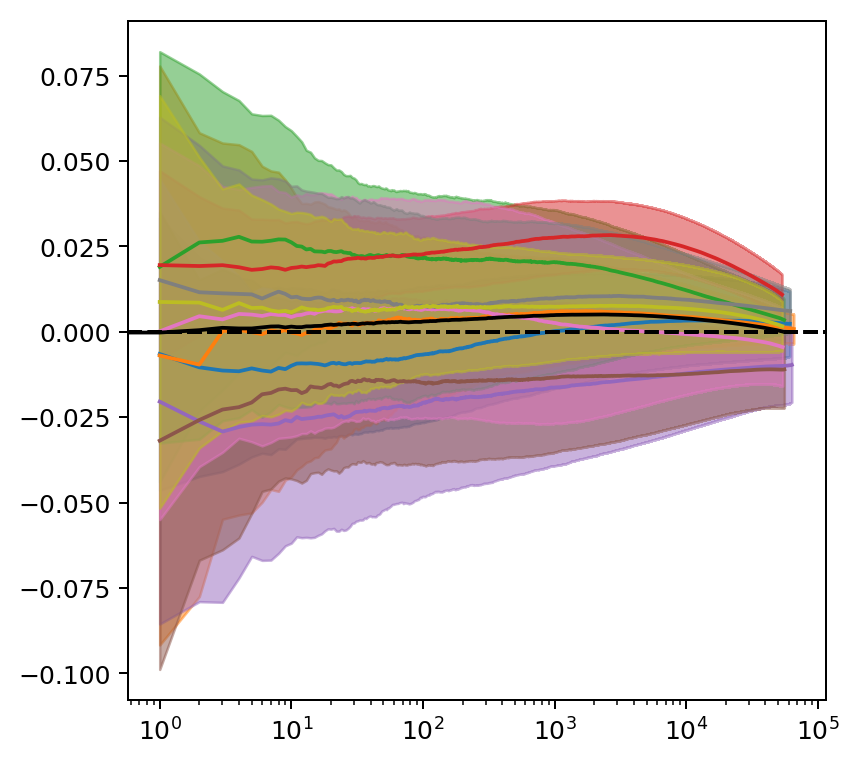

In [19]:
def plot_p(ax, results_sum, results_diff):
    print('plotting')
    for idx_run, (run_result_sum, run_result_diff) in enumerate(zip(results_sum, results_diff)):
        x = list()
        num_voxels = list()
        y = list()
        p_whole = None
        min_whole_brain_p = None
        max_whole_brain_p = None
        for p_value in np.linspace(0.5, .01, 50):
            indicator_voxels = run_result_sum.p_values <= p_value
            num_voxels.append(np.sum(indicator_voxels))
            perm_values = run_result_diff.permutation_values[:, indicator_voxels]
            true_values = run_result_diff.true_values[indicator_voxels]
            # _, whole_brain_p_value = wilcoxon(np.reshape(true_values, -1))
            # whole_brain_p_value = np.mean(np.abs(perm_values) >= np.abs(true_values))
            whole_brain_p_value = np.mean(np.abs(np.mean(perm_values, axis=1)) >= np.abs(np.mean(true_values)))
            if whole_brain_p_value < .05 and p_whole is None:
                p_whole = p_value
            whole_brain_value = np.mean(true_values)
            if min_whole_brain_p is None or whole_brain_p_value < min_whole_brain_p:
                min_whole_brain_p = whole_brain_p_value
            if max_whole_brain_p is None or whole_brain_p_value > max_whole_brain_p:
                max_whole_brain_p = whole_brain_p_value
            x.append(p_value)
            y.append(whole_brain_value)
        line_handle = ax.plot(x, y)[0]
        print(min_whole_brain_p, max_whole_brain_p)
        if p_whole is not None:
            c = line_handle.get_color()
            ax.axvline(p_whole - idx_run * .01, color=c, linestyle='--')
        num_voxels = list(reversed(num_voxels))
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(num_voxels)
        ax2.tick_params(axis='x', which='major', pad=idx_run * 15)

def plot_model_proportion(ax, results_sum, results_diff):
    print('plotting')
    y = list()
    for idx_run, (run_result_sum, run_result_diff) in enumerate(zip(results_sum, results_diff)):
        indices_sorted = np.argsort(-run_result_sum.true_values)
        diff_values = run_result_diff.true_values[indices_sorted]
        indicator_model_a = diff_values > 0
        indicator_model_b = diff_values < 0
        count_a = np.cumsum(indicator_model_a)
        count_b = np.cumsum(indicator_model_b)
        proportion_a = count_a / (count_a + count_b)
        y.append(proportion_a)
    x = np.arange(1, len(results_sum[0].true_values) + 1)
    y = np.array(y).T
    ax.plot(x[50:], y[50:])
    ax.axhline(0.5, color='black', linestyle='--')

def plot_model_diff(ax, plot_info):
    all_means = [p.mean for p in plot_info]
    min_k = min(len(m) for m in all_means)
    for i in range(len(all_means)):
        all_means[i] = all_means[i][:min_k]
    subj_mean = np.mean(all_means, axis=0)
    for p in plot_info:
#         if p.subject == 'I':
#             print('skipping')
#             continue
        line_handler = ax.plot(np.arange(1, len(p.mean) + 1), p.mean, label=p.subject)[0]
        line_color = line_handler.get_color()
        ax.fill_between(
            np.arange(1, len(p.mean) + 1), p.mean - p.std_err, p.mean + p.std_err, 
            color=line_color, alpha=0.5)
        
        ax.set_xscale('log')
        ax.axhline(0, color='black', linestyle='--')
    ax.plot(subj_mean, color='black')
    # ax.legend()

        
#     ax.scatter(plot_info.a_accuracy, plot_info.b_accuracy, alpha=0.5)
#     ax.plot([0.0, 1], [0.0, 1], 'k')
#     fit_params = np.polyfit(plot_info.a_accuracy, plot_info.b_accuracy, 1)
#     ax.plot([0.0, 1.0], np.poly1d(fit_params)([0.0, 1.0]), 'r')
#     ax.set_aspect('equal', 'box')
#     ax.set_ylim([0.5, 1])
#     ax.set_xlim([0.5, 1])
#     if plot_info.idx_subject < 6:
#         ax.set_xticks([])
#     if plot_info.idx_subject % 3 != 0:
#         ax.set_yticks([])
#     ax.tick_params(labelsize=11)
    
# render_subplot_artists(
#     [SubplotArtist(
#         width=3, height=3, 
#         render_fn=(lambda r_s, r_d: lambda ax: plot_model_proportion(ax, r_s, r_d))(r_sum, r_diff)) 
#      for s, (r_a, r_b, r_sum, r_diff) in subject_results], 
#     num_columns=3, dpi=180, is_tight_layout=True)
# render_subplot_artists(
#     [SubplotArtist(
#         width=3, height=3, 
#         render_fn=(lambda p: lambda ax: plot_model_diff(ax, p.a_accuracy, p.b_accuracy))(pi)) for pi in plot_info], 
#     num_columns=3, dpi=180, is_tight_layout=True)
render_subplot_artists(
    [SubplotArtist(
        width=5, height=5, 
        render_fn=lambda ax: plot_model_diff(ax, plot_info))], dpi=180)

In [7]:
import pickle
with open('fine_tuned_variation.bin', 'wb') as f:
    pickle.dump(plot_info, f)

In [8]:
import pickle
with open('meg_fmri.bin', 'rb') as f:
    plot_info = pickle.load(f)

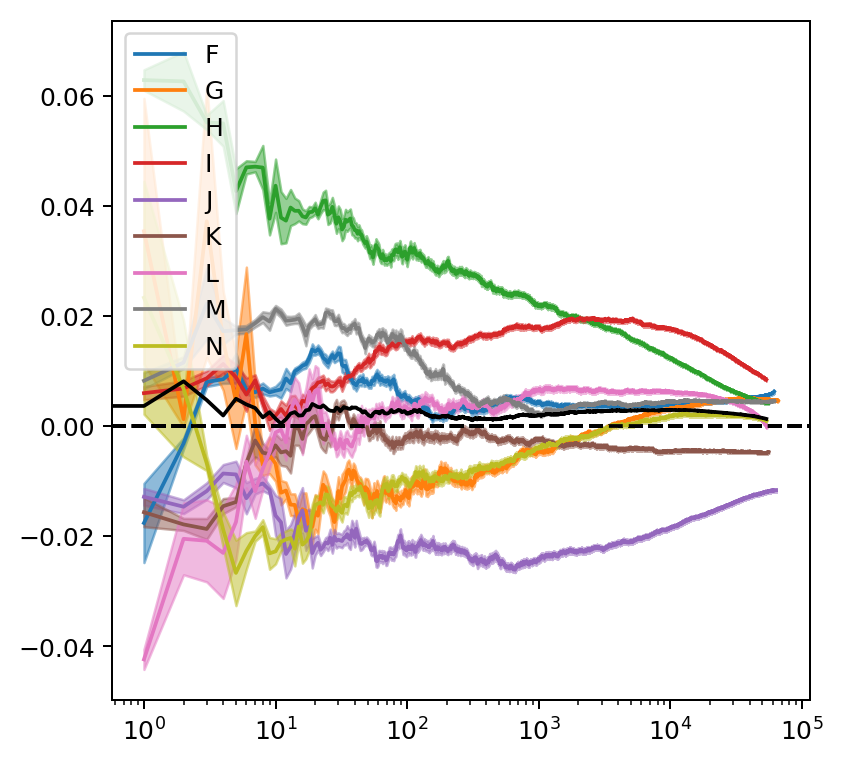

In [16]:
render_subplot_artists(
    [SubplotArtist(
        width=5, height=5, 
        render_fn=lambda ax: plot_model_diff(ax, plot_info))], dpi=180)

In [4]:
result_queries = list()
subjects = ['H', 'I', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_meg_simple_fmri', 
            'hp_fmri_20_linear', 
            ('hp_fmri_{}'.format(subject),), 
            ('hp_fmri_{}'.format(subject),),
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            # vmin = max(0, vmin)
            vmin = np.nanquantile(data, 0.8)
        else:
            # vmin = max(0.5, vmin)
            vmin = np.nanquantile(data, 0.8)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

Process ForkProcess-96:
Process ForkProcess-94:
Process ForkProcess-83:
Process ForkProcess-78:
Process ForkProcess-95:
Process ForkProcess-89:
Process ForkProcess-87:
Process ForkProcess-81:
Process ForkProcess-77:
Process ForkProcess-85:
Process ForkProcess-92:
Process ForkProcess-93:
Process ForkProcess-80:
Process ForkProcess-75:
Process ForkProcess-74:
Process ForkProcess-91:
Process ForkProcess-79:
Process ForkProcess-88:
Process ForkProcess-76:
Process ForkProcess-90:
Process ForkProcess-86:
Process ForkProcess-73:
Process ForkProcess-84:
Process ForkProcess-82:
Traceback (most recent call last):
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item

KeyboardInterrupt: 

  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/

  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/usr0/home/drschwar/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  Fi

Stopping server


In [2]:
result_queries = list()
subjects = ['H', 'I', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_meg_simple_fmri', 
            'hp_meg_simple_fmri', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom(
                    'hp_fmri_meg',
                    loss_tasks=('hp_meg',))), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_meg_simple_fmri, ('loss_tasks', 'load_from'), H, pove, min: -0.5151137113571167, max: 0.2280595898628235
hp_meg_simple_fmri, ('H',), H, pove, min: -0.6288654804229736, max: 0.1741199493408203
hp_meg_simple_fmri, ('loss_tasks', 'load_from'):('H',), H, pove, min: -0.08359026908874512, max: 0.2905418872833252
hp_meg_simple_fmri, ('loss_tasks', 'load_from'), I, pove, min: -0.3829460144042969, max: 0.3371664881706238
hp_meg_simple_fmri, ('I',), I, pove, min: -0.4993147850036621, max: 0.29536861181259155
hp_meg_simple_fmri, ('loss_tasks', 'load_from'):('I',), I, pove, min: -0.1232956051826477, max: 0.4392753839492798
hp_meg_simple_fmri, ('loss_tasks', 'load_from'), K, pove, min: -0.36397385597229004, max: 0.13737374544143677
hp_meg_simple_fmri, ('K',), K, pove, min: -0.42689549922943115, max: 0.1624617576599121
hp_meg_simple_fmri, ('loss_tasks', 'load_from'):('K',), K, pove, min: -0.10012644529342651, max: 0.1602414846420288
hp_meg_simple_fmri, ('loss_tasks', 'load_from'), L, pove, min: -

/usr0/home/drschwar/src/bert_erp/analysis.py:943: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 42753


<WebApp(Thread-4, started 140501206378240)>

(329, 54123)


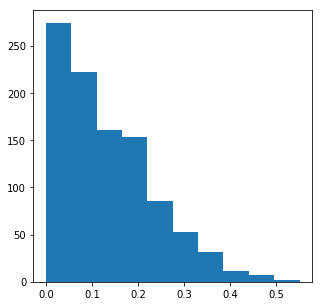

In [3]:
print(err_a.shape)
render_subplot_artists(SubplotArtist(width=5, height=5, render_fn=lambda ax: ax.hist(permutations[:, 0])))

In [1]:
paths = Paths()
erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')
training_variations, settings, num_runs, _, aux_loss = named_variations('erp_hp_meg')
aggregated, count_runs = read_variation_results(
    paths, 
    'erp_hp_meg',
    # TrainingVariation(('hp_meg',), load_from=LoadFrom('hp_meg_erp', loss_tasks=erp_tasks)),
    TrainingVariation(
                ('hp_meg',), load_from=LoadFrom(
                    'hp_meg_erp',
                    TrainingVariation(erp_tasks, load_from=LoadFrom('hp_fmri_meg', loss_tasks=('hp_meg',))))),
    aux_loss, num_runs, compute_scalar=False, k_vs_k_num_samples=1000, k_vs_k_feature_axes={'hp_meg': (-2, -1)})  

NameError: name 'Paths' is not defined

-0.0124600725 0.12232462


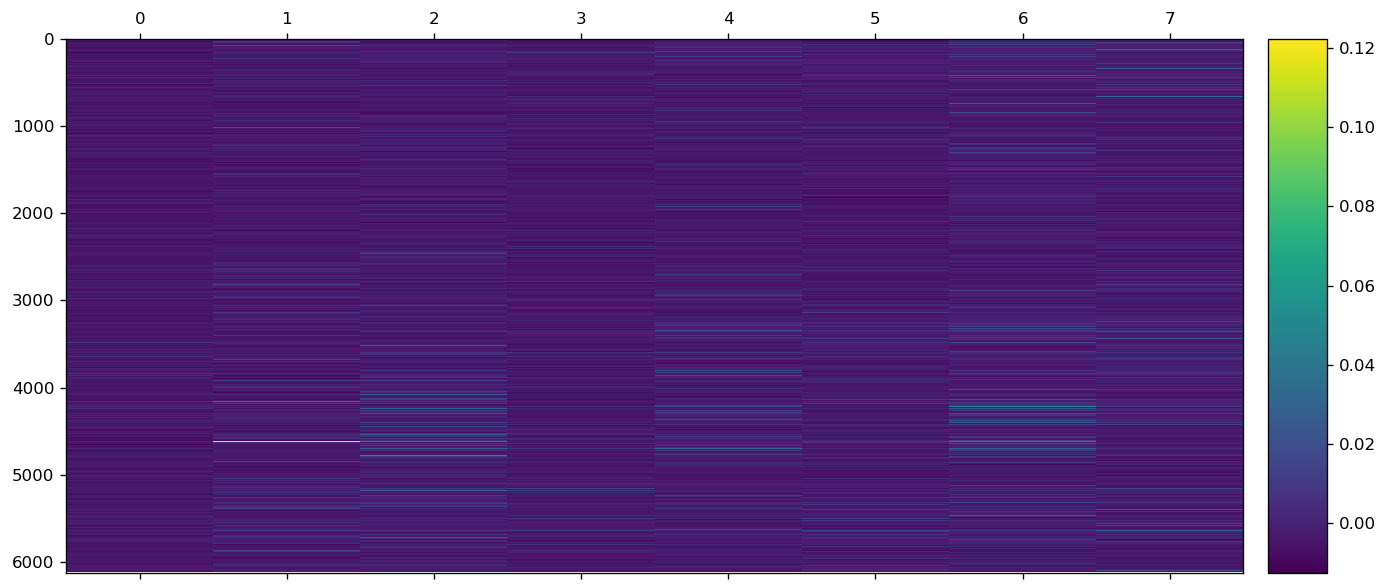

In [5]:
metric = 'pove'
data = np.nanmean(np.array(aggregated['hp_meg'].values(metric)), axis=0)
if len(data.shape) > 2:
    # data = np.transpose(data, axes=(1, 0, 2))
    data = np.reshape(data, (data.shape[0], -1))
print(np.nanmin(data), np.nanmax(data))
colorbar = ColorbarArtist(width=0.5, height=5)
render_subplot_artists(
    [SubplotArtist(width=10, height=5, render_fn=lambda ax: matshow(ax, data.T), colorbar_artist=colorbar),
     colorbar], dpi=120, num_columns=2, is_tight_layout=True)

In [3]:
paths = Paths()
fmri_subjects_ = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
# fmri_subjects_ = ['H', 'I', 'K', 'L']
fmri_tasks = tuple('hp_fmri_{}'.format(s) for s in fmri_subjects_)
training_variations, settings, num_runs, _, aux_loss = named_variations('hp_fmri_meg_joint')
aggregated_a, count_runs_a = read_variation_results(
    paths, 'hp_fmri_meg_joint', 
    fmri_tasks + ('hp_meg',),
    # TrainingVariation(('hp_meg', 'hp_fmri_I'), load_from=LoadFrom('hp_fmri_20', loss_tasks=('hp_fmri_I',))), 
    aux_loss, num_runs, compute_scalar=False, k_vs_k_num_samples=0, k_vs_k_feature_axes={'hp_meg': (-2, -1)})  
aggregated_b, count_runs_b = read_variation_results(
    paths, 'hp_fmri_meg', ('hp_meg',), aux_loss, num_runs, compute_scalar=False, 
    k_vs_k_num_samples=0, k_vs_k_feature_axes={'hp_meg': (-2, -1)})

In [4]:
metric = 'pove'
share_vmin_vmax = True
data_a = np.nanmean(np.array(aggregated_a['hp_meg'].values(metric)), axis=0)
if len(data_a.shape) > 2:
    # data_a = np.transpose(data_a, axes=(1, 0, 2))
    data_a = np.reshape(data_a, (data_a.shape[0], -1))
print(np.nanmin(data_a), np.nanmax(data_a))
data_b = np.nanmean(np.array(aggregated_b['hp_meg'].values(metric)), axis=0)
if len(data_b.shape) > 2:
    # data_b = np.transpose(data_b, axes=(1, 0, 2))
    data_b = np.reshape(data_b, (data_b.shape[0], -1))
print(np.nanmin(data_b), np.nanmax(data_b))
if metric == 'mse':
    thresh = 0.95
    data_ab = np.where(np.logical_or(data_a <= thresh, data_b <= thresh), data_a - data_b, np.nan)
else:
    if metric == 'r_seq':
        thresh = 0.0
    elif metric == '20_vs_20':
        thresh = 0.5
    elif metric == 'pove':
        thresh = 0.005
    else:
        raise ValueError('need to define thresh for metric: {}'.format(metric))
    data_ab = np.where(np.logical_or(data_a >= thresh, data_b >= thresh), data_a - data_b, np.nan)
ab_vmin = np.nanmin(data_ab)
ab_vmax = np.nanmax(data_ab)
if ab_vmin < 0 and ab_vmax < 0:
    ab_vmax = -ab_vmin
elif ab_vmin > 0 and ab_vmax > 0:
    ab_vmin = -ab_vmax
else:
    min_max = max(abs(ab_vmin), abs(ab_vmax))
    ab_vmin, ab_vmax = -min_max, min_max
print(np.nanmin(data_ab), np.nanmax(data_ab))

-0.013074815 0.043729424
-0.018250376 0.09478977
-0.05830033 0.013401285


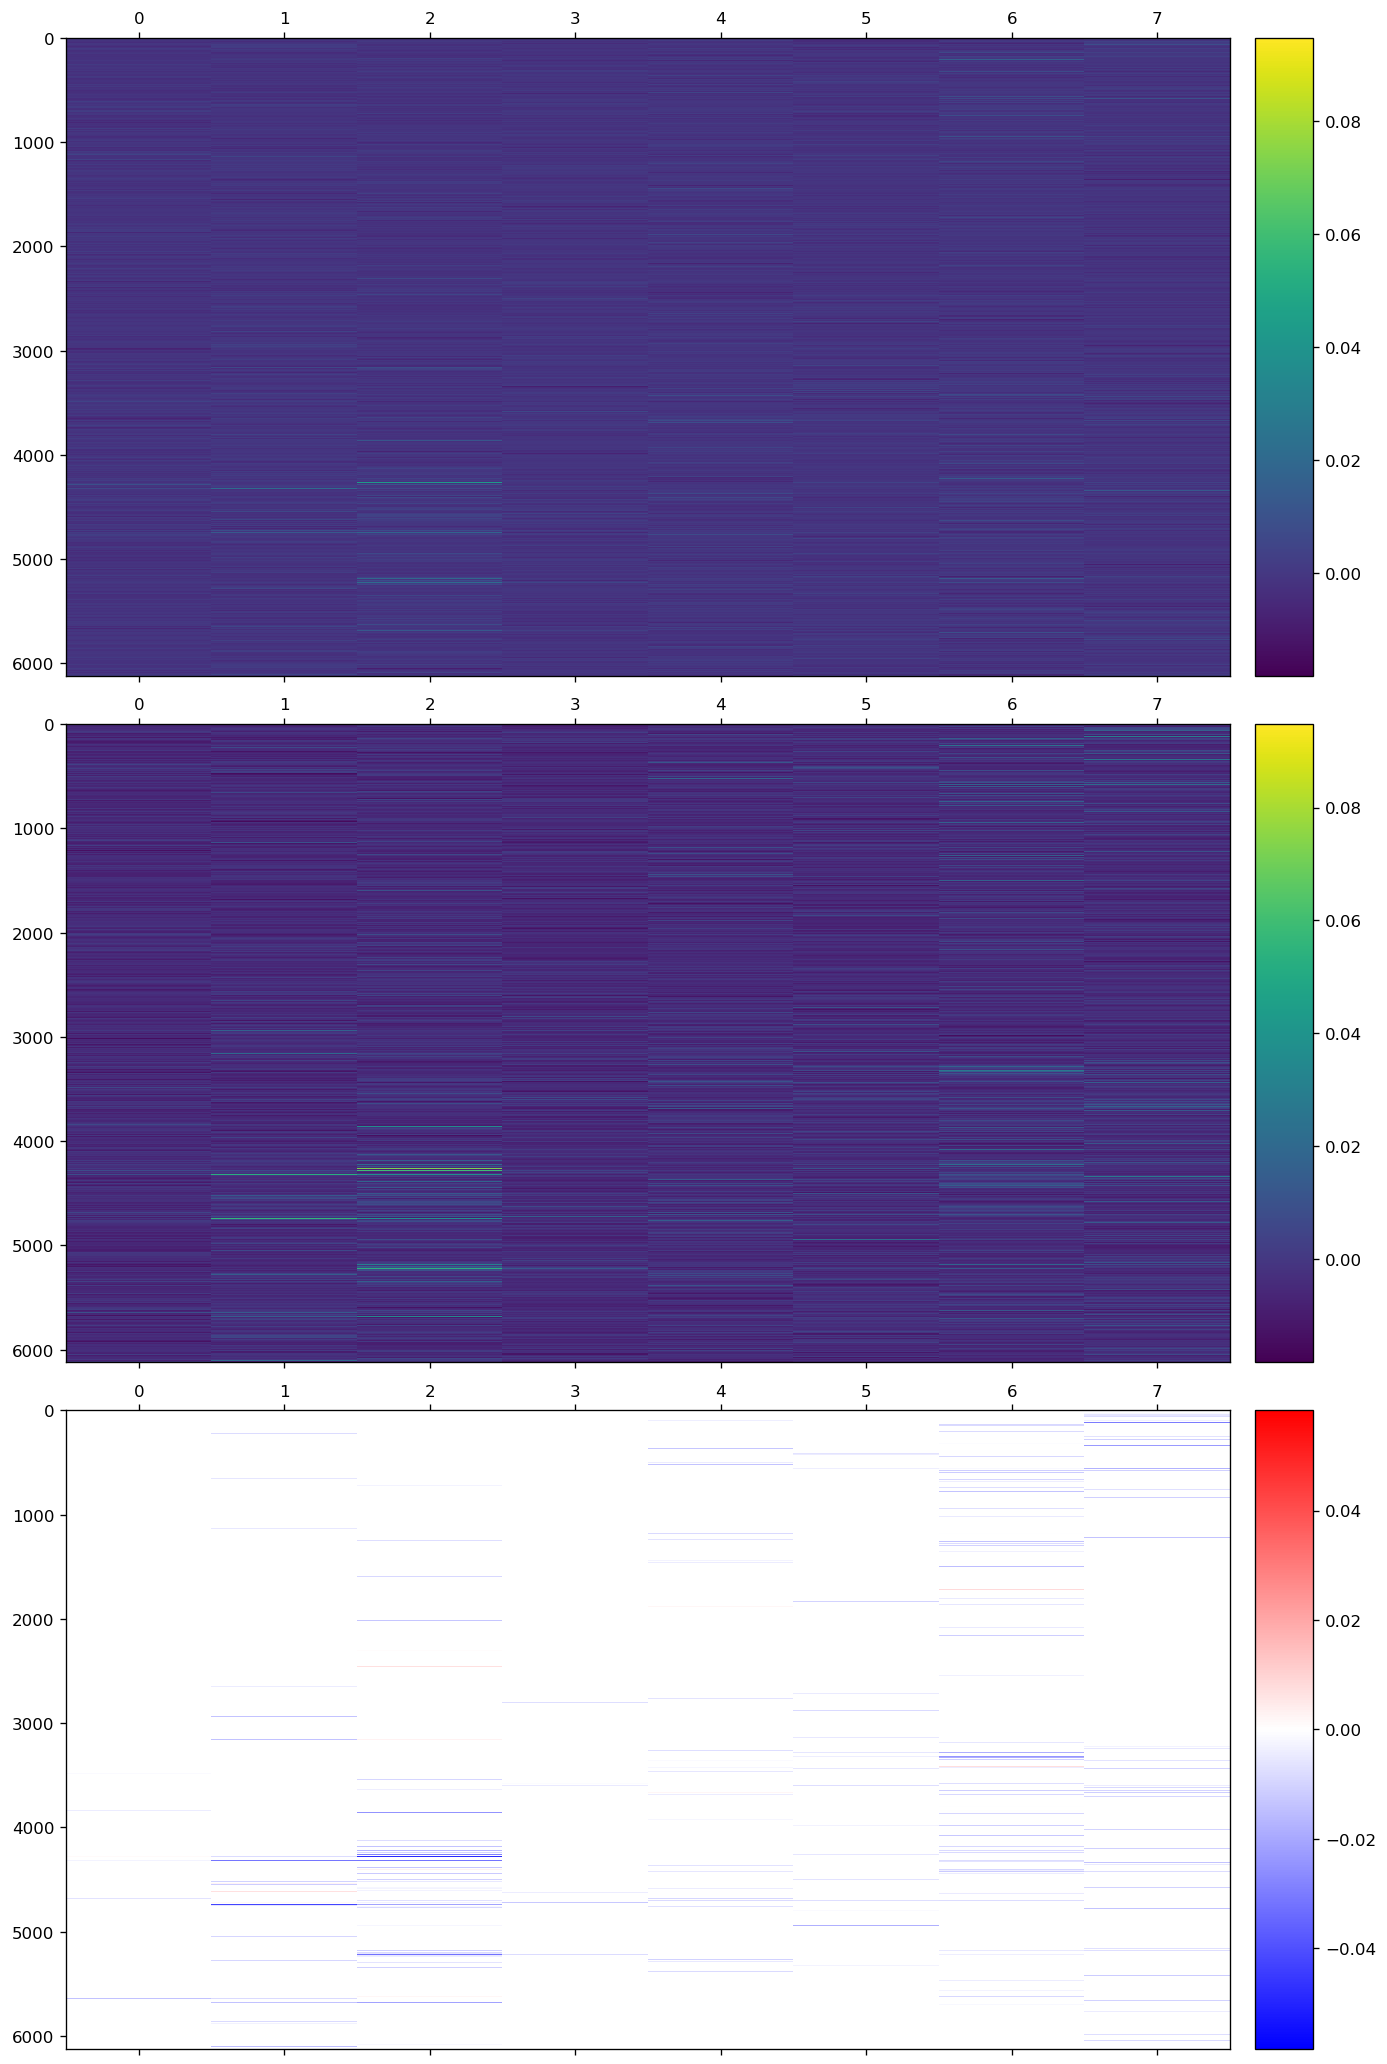

In [5]:
colorbar_a = ColorbarArtist(width=0.5, height=5)
colorbar_b = ColorbarArtist(width=0.5, height=5)
colorbar_ab = ColorbarArtist(width=0.5, height=5)
vmin_a = None
vmax_a = None
vmin_b = None
vmax_b = None
if share_vmin_vmax:
    vmin_a = vmin_b = min(np.nanmin(data_a), np.nanmin(data_b))
    vmax_a = vmax_b = max(np.nanmax(data_a), np.nanmax(data_b))
render_subplot_artists(
    [SubplotArtist(width=10, height=5, render_fn=lambda ax: matshow(ax, data_a.T, vmin=vmin_a, vmax=vmax_a), 
                   colorbar_artist=colorbar_a),
     colorbar_a,
     SubplotArtist(width=10, height=5, render_fn=lambda ax: matshow(ax, data_b.T, vmin=vmin_b, vmax=vmax_b), 
                   colorbar_artist=colorbar_b),
     colorbar_b,
     SubplotArtist(width=10, height=5, render_fn=lambda ax: matshow(ax, data_ab.T, vmin=ab_vmin, vmax=ab_vmax, cmap='bwr'), colorbar_artist=colorbar_ab),
     colorbar_ab], dpi=120, num_columns=2, is_tight_layout=True)

In [16]:
result_queries = list()
def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

for metric in ['pove', 'k_vs_k']:
    append_query_triple('hp_fmri_meg', 'hp_fmri_meg', ('hp_meg', 'hp_fmri_I'), ('hp_fmri_I',), metric, 'I')
results = query_results(paths, result_queries)

print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])

volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_fmri_meg, ('hp_meg', 'I'), I, pove, min: -0.40124809741973877, max: 0.2922930121421814
hp_fmri_meg, ('I',), I, pove, min: -0.5472944974899292, max: 0.2898572087287903
hp_fmri_meg, ('hp_meg', 'I'):('I',), I, pove, min: -0.1386106014251709, max: 0.21182507276535034
hp_fmri_meg, ('hp_meg', 'I'), I, k_vs_k, min: 0.112, max: 0.984
hp_fmri_meg, ('I',), I, k_vs_k, min: 0.115, max: 0.971
hp_fmri_meg, ('hp_meg', 'I'):('I',), I, k_vs_k, min: -0.34299999999999997, max: 0.37200000000000005


/usr0/home/drschwar/src/bert_erp/analysis.py:942: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 9844


<WebApp(Thread-6, started 139950810007296)>

In [3]:
result_queries = list()
subjects = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
# subjects = ['H', 'I', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    # result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    # result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

joint_fmri = tuple('hp_fmri_{}'.format(s) for s in subjects)
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_fmri_meg_joint_45', 
            'hp_meg_fmri', 
            joint_fmri + ('hp_meg',),
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), F, pove, min: -0.2876232862472534, max: 0.14450401067733765
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), G, pove, min: -0.2202777862548828, max: 0.096538245677948
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), H, pove, min: -0.17736554145812988, max: 0.08351993560791016
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), I, pove, min: -0.18392837047576904, max: 0.16255927085876465
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), J, pove, min: -0.28910911083221436, max: 0.179066002368927
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), K, pove, min: -0.19819879531860352, max: 0.09698307514190674
hp_fmri_meg_joint_45, ('F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'hp_meg'), L, pove, min: -0.3653041124343872, max: 0.12428581714630127
hp_fmri_meg_joint_45, ('F',

/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Started server on port 22660


<WebApp(Thread-5, started 140055301564160)>

In [3]:
result_queries = list()
subjects = ['H', 'I', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_meg_fmri', 
            'hp_meg_fmri', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom(
                    'erp_hp_meg',
                    TrainingVariation(
                        ('hp_meg',), load_from=LoadFrom(
                            'hp_meg_erp',
                            TrainingVariation(erp_tasks, load_from=LoadFrom(
                                'hp_fmri_meg',
                                loss_tasks=('hp_meg',))))))), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_meg_fmri, ('loss_tasks', 'load_from'), H, pove, min: -0.5024896860122681, max: 0.226889967918396
hp_meg_fmri, ('H',), H, pove, min: -0.6288654804229736, max: 0.1741199493408203
hp_meg_fmri, ('loss_tasks', 'load_from'):('H',), H, pove, min: -0.11269629001617432, max: 0.2996670603752136
hp_meg_fmri, ('loss_tasks', 'load_from'), I, pove, min: -0.3098745346069336, max: 0.32493335008621216
hp_meg_fmri, ('I',), I, pove, min: -0.4993147850036621, max: 0.29536861181259155
hp_meg_fmri, ('loss_tasks', 'load_from'):('I',), I, pove, min: -0.13991260528564453, max: 0.29099422693252563
hp_meg_fmri, ('loss_tasks', 'load_from'), K, pove, min: -0.3259211778640747, max: 0.12006103992462158
hp_meg_fmri, ('K',), K, pove, min: -0.42689549922943115, max: 0.1624617576599121
hp_meg_fmri, ('loss_tasks', 'load_from'):('K',), K, pove, min: -0.16911673545837402, max: 0.18505269289016724
hp_meg_fmri, ('loss_tasks', 'load_from'), L, pove, min: -0.8701231479644775, max: 0.1805441975593567
hp_meg_fmri, ('L',), L, 

/usr0/home/drschwar/src/bert_erp/analysis.py:943: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 25782


<WebApp(Thread-4, started 140032774702848)>

In [2]:
result_queries = list()
subjects = ['H', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_meg_simple_fmri', 
            'hp_HKL_from_I', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom(
                    'hp_fmri_meg',
                    loss_tasks=('hp_meg',))), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
    subject = 'I'
    append_query_triple(
            'hp_meg_simple_fmri', 
            'hp_fmri_20_linear', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom(
                    'hp_fmri_meg',
                    loss_tasks=('hp_meg',))), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

TrainingVariation(loss_tasks=('hp_fmri_L',), load_from=LoadFrom(variation_name='hp_fmri_meg', loss_tasks=('hp_meg',), map_run=None)) 179e5fc975eca579028f8769b4730ade3418d7524fac3604f74d794518454b12
('hp_fmri_K',) 3886bd9b9a04b456e2d8b4c52b7dad0a289ecfb48b7115c3ead6e0b934e07a9a
TrainingVariation(loss_tasks=('hp_fmri_H',), load_from=LoadFrom(variation_name='hp_fmri_meg', loss_tasks=('hp_meg',), map_run=None)) 0b9cc647b4dd4b4c293a5d99581ce46dea94166d92e04f1698b528ab853bd342
('hp_fmri_I',) 6a8b27b43d8353827c8ea1d8bacc0a941f09d3d68086b189bcbf7affd2368ed9
TrainingVariation(loss_tasks=('hp_fmri_I',), load_from=LoadFrom(variation_name='hp_fmri_meg', loss_tasks=('hp_meg',), map_run=None)) 0fbf448afcf22f12dbb327e3a3c7be2afb1ad5b783a4b8e69fc44f6891d58d07
('hp_fmri_H',) 1dde3bc9436f1085d637ff934730f32ec7bf39d82e82a6e056d5227f512640d5
TrainingVariation(loss_tasks=('hp_fmri_K',), load_from=LoadFrom(variation_name='hp_fmri_meg', loss_tasks=('hp_meg',), map_run=None)) 7647340873fdb135f299b8192bcd28991

/usr0/home/drschwar/src/bert_erp/analysis.py:944: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 50346


<WebApp(Thread-4, started 139684197517056)>

In [3]:
result_queries = list()
subjects = ['H', 'I', 'K', 'L']

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

erp_tasks = ('epnp', 'pnp', 'elan', 'lan', 'n400', 'p600')    
    
for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'erp_hp_fmri', 
            'erp_hp_fmri', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom(
                    'hp_meg_erp',
                    loss_tasks=erp_tasks)), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

erp_hp_fmri, ('loss_tasks', 'load_from'), H, pove, min: -0.645361065864563, max: 0.1694430708885193
erp_hp_fmri, ('H',), H, pove, min: -0.6288654804229736, max: 0.1741199493408203
erp_hp_fmri, ('loss_tasks', 'load_from'):('H',), H, pove, min: -0.14606964588165283, max: 0.10756981372833252
erp_hp_fmri, ('loss_tasks', 'load_from'), I, pove, min: -0.48843491077423096, max: 0.30709052085876465
erp_hp_fmri, ('I',), I, pove, min: -0.4993147850036621, max: 0.29536861181259155
erp_hp_fmri, ('loss_tasks', 'load_from'):('I',), I, pove, min: -0.14918482303619385, max: 0.15317517518997192
erp_hp_fmri, ('loss_tasks', 'load_from'), K, pove, min: -0.470552921295166, max: 0.17117929458618164
erp_hp_fmri, ('K',), K, pove, min: -0.42689549922943115, max: 0.1624617576599121
erp_hp_fmri, ('loss_tasks', 'load_from'):('K',), K, pove, min: -0.07178962230682373, max: 0.09829050302505493
erp_hp_fmri, ('loss_tasks', 'load_from'), L, pove, min: -0.8809933662414551, max: 0.22954261302947998
erp_hp_fmri, ('L',), L

/usr0/home/drschwar/src/bert_erp/analysis.py:943: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 48562


<WebApp(Thread-5, started 140501197985536)>

In [17]:
result_queries = list()
subjects = ['H', 'I', 'K', 'L']
joint = tuple('hp_fmri_{}'.format(s) for s in subjects)

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple('hp_HIKL_joint', 'hp_HIKL_independent', joint, ('hp_fmri_{}'.format(subject),), metric, subject)
results = query_results(paths, result_queries)
print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_HIKL_joint, ('H', 'I', 'K', 'L'), H, pove, min: -0.35651516914367676, max: 0.15677529573440552
hp_HIKL_independent, ('H',), H, pove, min: -0.4116889238357544, max: 0.1734696626663208
hp_HIKL_joint:hp_HIKL_independent, ('H', 'I', 'K', 'L'):('H',), H, pove, min: -0.10689890384674072, max: 0.21353954076766968
hp_HIKL_joint, ('H', 'I', 'K', 'L'), I, pove, min: -0.333903431892395, max: 0.298806369304657
hp_HIKL_independent, ('I',), I, pove, min: -0.3504517078399658, max: 0.27244436740875244
hp_HIKL_joint:hp_HIKL_independent, ('H', 'I', 'K', 'L'):('I',), I, pove, min: -0.1471439003944397, max: 0.182184100151062
hp_HIKL_joint, ('H', 'I', 'K', 'L'), K, pove, min: -0.475807785987854, max: 0.14668351411819458
hp_HIKL_independent, ('K',), K, pove, min: -0.33545076847076416, max: 0.12173634767532349
hp_HIKL_joint:hp_HIKL_independent, ('H', 'I', 'K', 'L'):('K',), K, pove, min: -0.14446121454238892, max: 0.10842233896255493
hp_HIKL_joint, ('H', 'I', 'K', 'L'), L, pove, min: -0.6843609809875488, m

/usr0/home/drschwar/src/bert_erp/analysis.py:942: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 1856


<WebApp(Thread-7, started 139950801614592)>

In [33]:
result_queries = list()
subjects = ['H', 'K', 'L']
joint = tuple('hp_fmri_{}'.format(s) for s in subjects)

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_HKL_from_I', 
            'hp_HKL_from_I', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom('hp_fmri_20', ('hp_fmri_I',))), 
            ('hp_fmri_{}'.format(subject),), 
            metric, 
            subject)

def alias_training_variation(training_variation):
    if training_variation is None:
        return None
    if isinstance(training_variation, TrainingVariation):
        return ('from_I',)
    else:
        return ('vanilla',)

def alias_training_variations(result_query):
    result_query.training_variation = alias_training_variation(result_query.training_variation)
    result_query.second_training_variation = alias_training_variation(result_query.second_training_variation)
    return result_query
    
results = query_results(paths, result_queries)
results = [(alias_training_variations(r[0]),) + r[1:] for r in results]

print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if vmin > 0 and vmax > 0:
            vmin = 0
        elif vmin < 0 and vmax < 0:
            vmax = 0
        elif abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_HKL_from_I, ('from_I',), H, pove, min: -0.2630568742752075, max: 0.14549541473388672
hp_HKL_from_I, ('vanilla',), H, pove, min: -0.08494138717651367, max: 0.06563639640808105
hp_HKL_from_I, ('from_I',):('vanilla',), H, pove, min: -0.0608745813369751, max: 0.13196194171905518
hp_HKL_from_I, ('from_I',), K, pove, min: -0.1663963794708252, max: 0.09305751323699951
hp_HKL_from_I, ('vanilla',), K, pove, min: -0.09189033508300781, max: 0.0477757453918457
hp_HKL_from_I, ('from_I',):('vanilla',), K, pove, min: 0.014411211013793945, max: 0.09939414262771606
hp_HKL_from_I, ('from_I',), L, pove, min: -0.29193758964538574, max: 0.10599756240844727
hp_HKL_from_I, ('vanilla',), L, pove, min: -0.12345194816589355, max: 0.06137925386428833
hp_HKL_from_I, ('from_I',):('vanilla',), L, pove, min: -0.062001943588256836, max: 0.13802045583724976
hp_HKL_from_I, ('from_I',), H, k_vs_k, min: 0.116, max: 0.909
hp_HKL_from_I, ('vanilla',), H, k_vs_k, min: 0.169, max: 0.887
hp_HKL_from_I, ('from_I',):('vanill

/usr0/home/drschwar/src/bert_erp/analysis.py:942: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 61174


<WebApp(Thread-13, started 139950091659008)>

Stopping server
Stopping server


In [3]:
result_queries = list()
subjects = ['H', 'K', 'L']
joint = tuple('hp_fmri_{}'.format(s) for s in subjects)

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_HKL_from_I_fine_tune', 
            'hp_HKL_from_I', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom('hp_fmri_20', ('hp_fmri_I',))), 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom('hp_fmri_20', ('hp_fmri_I',))), 
            metric, 
            subject)

def alias_training_variation(training_variation):
    if training_variation is None:
        return None
    if isinstance(training_variation, TrainingVariation):
        return ('from_I',)
    else:
        return ('vanilla',)

def alias_training_variations(result_query):
    result_query.training_variation = alias_training_variation(result_query.training_variation)
    result_query.second_training_variation = alias_training_variation(result_query.second_training_variation)
    return result_query
    
results = query_results(paths, result_queries)
results = [(alias_training_variations(r[0]),) + r[1:] for r in results]

print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if vmin > 0 and vmax > 0:
            vmin = 0
        elif vmin < 0 and vmax < 0:
            vmax = 0
        elif abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

Stopping server
hp_HKL_from_I_fine_tune, ('from_I',), H, pove, min: -0.30520904064178467, max: 0.1744750738143921
hp_HKL_from_I, ('from_I',), H, pove, min: -0.14355361461639404, max: 0.11077189445495605
hp_HKL_from_I_fine_tune:hp_HKL_from_I, ('from_I',), H, pove, min: -0.18648755550384521, max: 0.1429097056388855
hp_HKL_from_I_fine_tune, ('from_I',), K, pove, min: -0.31136810779571533, max: 0.12890881299972534
hp_HKL_from_I, ('from_I',), K, pove, min: -0.10685300827026367, max: 0.08896011114120483
hp_HKL_from_I_fine_tune:hp_HKL_from_I, ('from_I',), K, pove, min: -0.16286689043045044, max: 0.128312885761261
hp_HKL_from_I_fine_tune, ('from_I',), L, pove, min: -0.5300936698913574, max: 0.14015811681747437
hp_HKL_from_I, ('from_I',), L, pove, min: -0.2368788719177246, max: 0.11504566669464111
hp_HKL_from_I_fine_tune:hp_HKL_from_I, ('from_I',), L, pove, min: -0.3377787470817566, max: 0.13422375917434692
hp_HKL_from_I_fine_tune, ('from_I',), H, k_vs_k, min: 0.141, max: 0.942
hp_HKL_from_I, (

/usr0/home/drschwar/src/bert_erp/analysis.py:849: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 16635


<WebApp(Thread-5, started 139905330046720)>

In [19]:
result_queries = list()
subjects = ['H', 'K', 'L']
joint = tuple('hp_fmri_{}'.format(s) for s in subjects)

def append_query_triple(a_name, b_name, a_train, b_train, metric, subject):
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train))
    result_queries.append(ResultQuery(b_name, metric, 'hp_fmri_{}'.format(subject), b_train))
    result_queries.append(ResultQuery(a_name, metric, 'hp_fmri_{}'.format(subject), a_train, b_name, b_train))

for metric in ['pove', 'k_vs_k']:
    for subject in subjects:
        append_query_triple(
            'hp_HKL_from_I_fine_tune', 
            'hp_HKL_from_I_fine_tune', 
            TrainingVariation(
                ('hp_fmri_{}'.format(subject),), load_from=LoadFrom('hp_fmri_20', ('hp_fmri_I',))),
            ('hp_fmri_{}'.format(subject),),
            metric, 
            subject)

def alias_training_variation(training_variation):
    if training_variation is None:
        return None
    if isinstance(training_variation, TrainingVariation):
        return ('from_I',)
    else:
        return ('vanilla',)

def alias_training_variations(result_query):
    result_query.training_variation = alias_training_variation(result_query.training_variation)
    result_query.second_training_variation = alias_training_variation(result_query.second_training_variation)
    return result_query
    
results = query_results(paths, result_queries)
results = [(alias_training_variations(r[0]),) + r[1:] for r in results]

print_min_max(results, key_shorten_fn=remove_hp_fmri_prefix)

def min_max_key(r):
    return len(r), r[0].key, r[0].metric

vmin_vmax = min_max_per_group(results, group_key_fn=min_max_key)

for k in vmin_vmax:
    vmin_vmax[k] = min(vmin_vmax[k][0]), max(vmin_vmax[k][1])
       
volume_dict = dict()
for result in results:
    key = min_max_key(result)
    if len(result) == 2:
        result_query, data = result
    else:
        result_query, data_1, data_2 = result
        data = data_1 - data_2
        if result_query.metric == 'pove':
            valid = np.logical_or(data_1 >= 0.05, data_2 >= 0.05)
        elif result_query.metric == 'k_vs_k':
            valid = np.logical_or(data_2 >= 0.5, data_2 >= 0.5)
        else:
            valid = np.full(data.shape, True)
        data = np.where(valid, data, np.nan)
    subject = result_query.key[len('hp_fmri_'):]
    vmin, vmax = vmin_vmax[key]
    # vmin, vmax = np.nanmin(data).item(), np.nanmax(data).item()
    if key[0] == 2:
        if key[2] == 'pove':
            vmin = max(0, vmin)
        else:
            vmin = max(0.5, vmin)
    else:
        if vmin > 0 and vmax > 0:
            vmin = 0
        elif vmin < 0 and vmax < 0:
            vmax = 0
        elif abs(vmin) > abs(vmax):
            vmax = -vmin
        else:
            vmin = -vmax
            
    key_format = '{combined_variation_set_name}, {combined_training_variation}, {key}, {metric}'
    volume_dict[key_format.format(**result_query.as_dict_with_combined_second(key_shorten_fn=remove_hp_fmri_prefix))] = \
        make_volume(np.nanmean(data, axis=0), subject, vmin=vmin, vmax=vmax, cmap='viridis' if len(result) == 2 else 'bwr')

cortex.webshow(volume_dict, open_browser=False)

hp_HKL_from_I_fine_tune, ('from_I',), H, pove, min: -0.3873159885406494, max: 0.21517080068588257
hp_HKL_from_I_fine_tune, ('vanilla',), H, pove, min: -0.46137988567352295, max: 0.14613914489746094
hp_HKL_from_I_fine_tune, ('from_I',):('vanilla',), H, pove, min: -0.19068282842636108, max: 0.2580404281616211
hp_HKL_from_I_fine_tune, ('from_I',), K, pove, min: -0.3673746585845947, max: 0.12356382608413696
hp_HKL_from_I_fine_tune, ('vanilla',), K, pove, min: -0.326383113861084, max: 0.10731226205825806
hp_HKL_from_I_fine_tune, ('from_I',):('vanilla',), K, pove, min: -0.1762235164642334, max: 0.12890172004699707
hp_HKL_from_I_fine_tune, ('from_I',), L, pove, min: -0.6975071430206299, max: 0.16139698028564453
hp_HKL_from_I_fine_tune, ('vanilla',), L, pove, min: -0.7080880403518677, max: 0.16246116161346436
hp_HKL_from_I_fine_tune, ('from_I',):('vanilla',), L, pove, min: -0.22959542274475098, max: 0.22574418783187866
hp_HKL_from_I_fine_tune, ('from_I',), H, k_vs_k, min: 0.097, max: 0.956
hp_

/usr0/home/drschwar/src/bert_erp/analysis.py:942: RuntimeWarning: invalid value encountered in greater_equal
  return np.logical_or(x >= 0.05, y >= 0.05)
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr

Started server on port 17877


<WebApp(Thread-9, started 139950791124736)>

In [2]:
variation = 'erp'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
eval_first = OrderedDict()
for idx_variation, training_variation in enumerate(training_variations):
    aggregated, count_runs = read_variation_results(paths, variation, training_variation, aux_loss, num_runs)
    for eval_key in aggregated:
        if eval_key not in eval_first:
            eval_first[eval_key] = OrderedDict()
        eval_first[eval_key][training_variation] = aggregated[eval_key].values('pove')

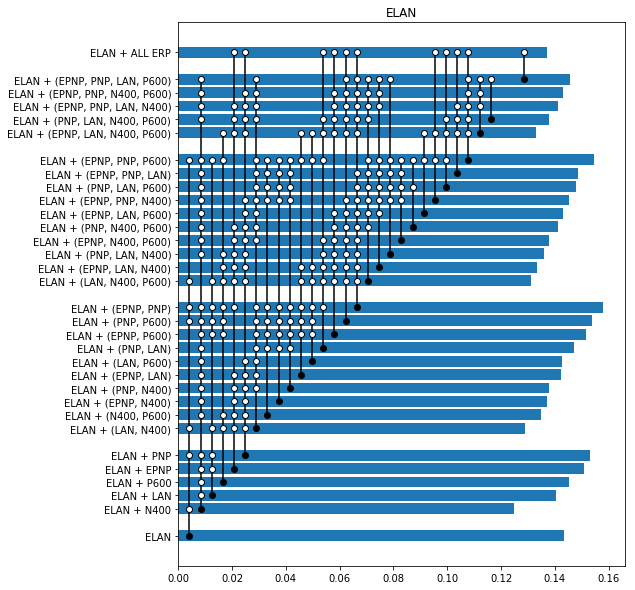

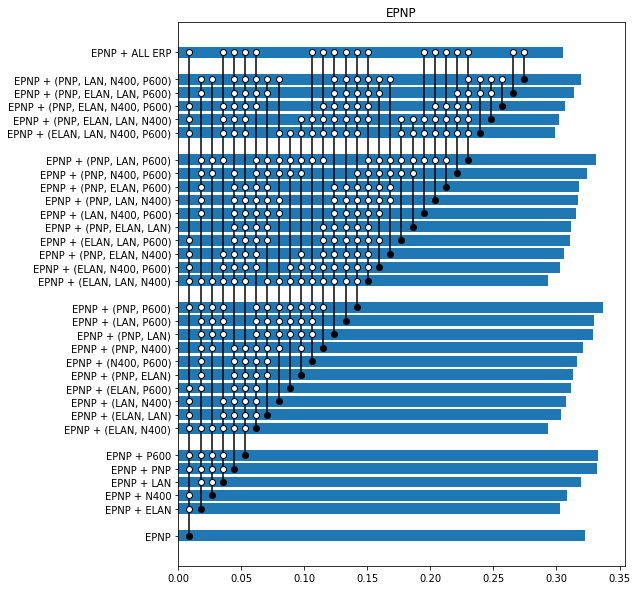

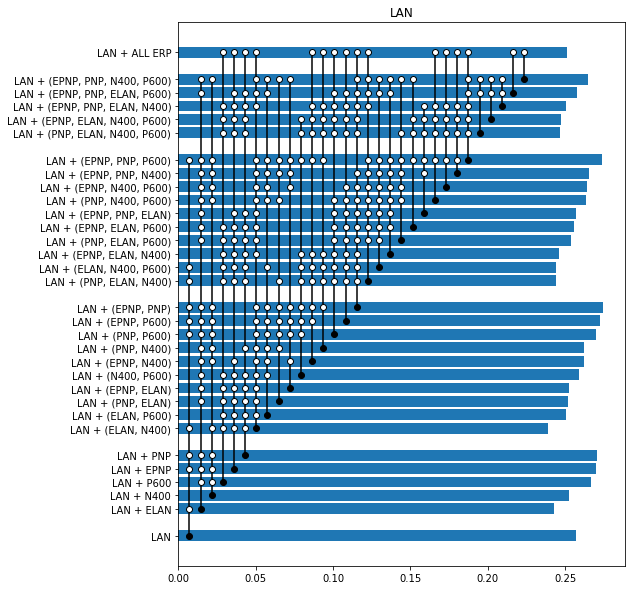

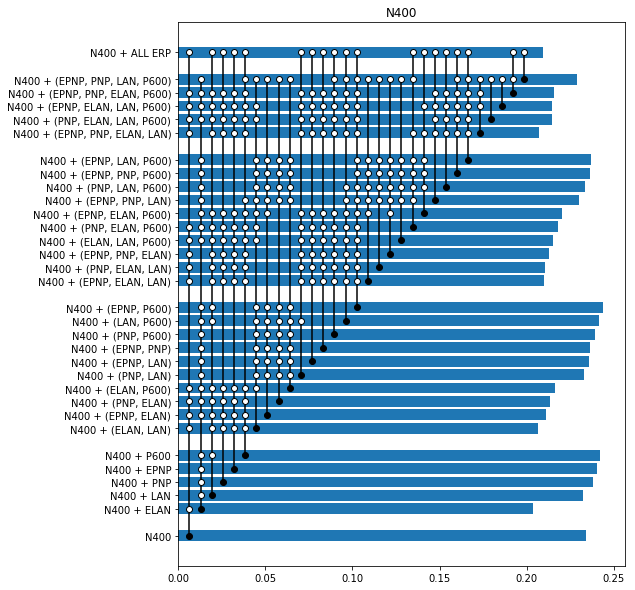

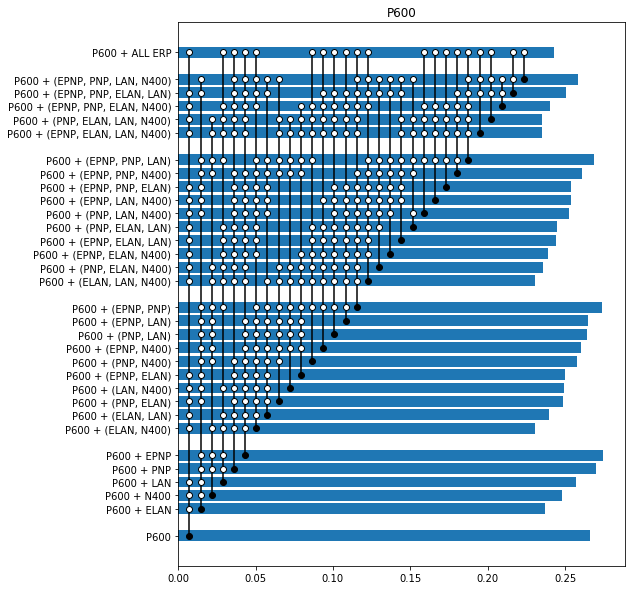

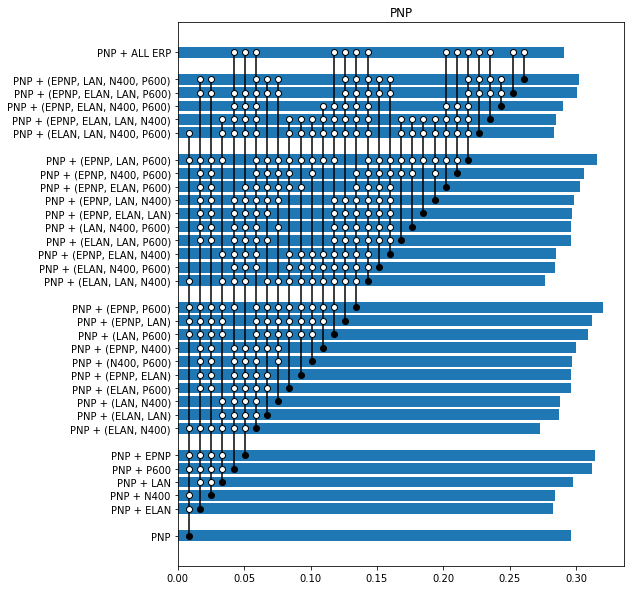

In [3]:
p_values = OrderedDict()
flat_p_values = list()
for eval_key in eval_first:
    p_values[eval_key] = OrderedDict()
    flat_keys = [k for k in eval_first[eval_key]]
    for i in range(len(flat_keys)):
        i_vals = eval_first[eval_key][flat_keys[i]]
        for j in range(i + 1, len(flat_keys)):
            j_vals = eval_first[eval_key][flat_keys[j]]
            _, p = ttest_rel(i_vals, j_vals)
            p_values[eval_key][(flat_keys[i], flat_keys[j])] = p
            p_values[eval_key][(flat_keys[j], flat_keys[i])] = p
            flat_p_values.append(p)

bhy_thresh = bhy_multiple_comparisons_procedure(np.array(flat_p_values), alpha=0.01, assume_independence=True)

for eval_key in sorted(eval_first):
    render_subplot_artists([SubplotArtist(
        width=8, height=10, 
        render_fn=lambda ax: bar_eval_key(
            ax, eval_first[eval_key], p_values[eval_key], bhy_thresh, make_label_fn))])

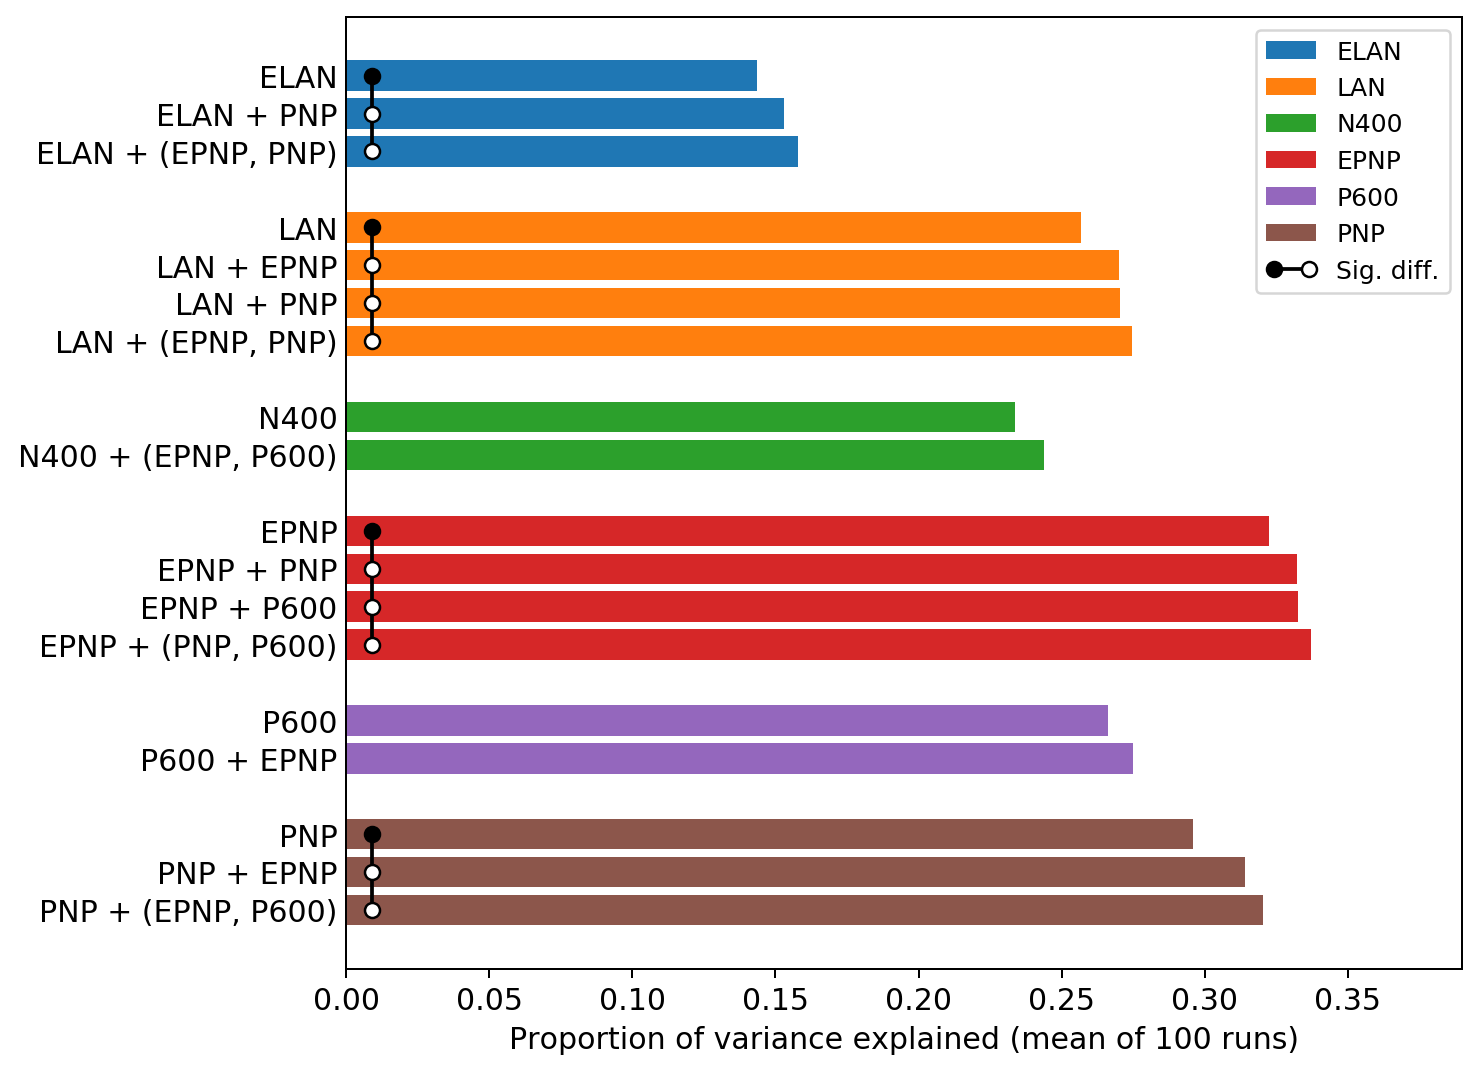

In [4]:
def bar_minimal(ax, eval_first, p_values, bhy_thresh):
        
    bar_groups = list()
    for eval_key in ('pnp', 'p600', 'epnp', 'n400', 'lan', 'elan'):
        eval_metrics = eval_first[eval_key]
        # erp_only = OrderedDict((k, eval_metrics[k]) for k in eval_metrics if _is_erp_only(k))
        erp_only = eval_metrics
        bar_groups.append(bar_group_best_for_eval(
            erp_only, p_values[eval_key], bhy_thresh, key_to_color, make_label_fn))
        bar_groups[-1].sort(lambda kv: (-len(kv[2]), -kv[1]), call_with_train_keys=True)
        bar_groups[-1].index_legend_bar = 0

#     for bar_group in bar_groups:
#         bar_group.hidden = set(idx for idx in range(0, len(bar_group) - 1))

#     for bar_group in bar_groups:
#         bar_group.hidden = set(idx for idx in range(1, len(bar_group) - 1))
        
    bar_grouped(ax, bar_groups, is_top_to_bottom=True)
    
    # ax.set_title('Training combinations of interest for each ERP signal')
    ax.set_xlabel('Proportion of variance explained (mean of 100 runs)')
    ax.set_xlim(0, 0.39)
    ax.tick_params(axis='y', which='both',length=0)

    for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(12)
    
    
render_subplot_artists([SubplotArtist(
        width=8, height=7, 
        render_fn=lambda ax: bar_minimal(ax, eval_first, p_values, bhy_thresh))], dpi=180)

In [1]:
curves = loss_curves_for_variation(Paths(), 'hp_fmri_meg')

def filter_curve(c, key):
    return c.key == key and key in c.training_variation

def filter_curve_fmri_good(c, subject):
    return c.key == 'hp_fmri_good_{}'.format(subject) and 'hp_fmri_{}'.format(subject) in c.training_variation

# curves = [c for c in curves if filter_curve_fmri_good(c, 'I') and len(c.training_variation) == 2]
curves = [c for c in curves if filter_curve(c, 'hp_meg') and len(c.training_variation) == 2]
average_unique_epochs_within_loss_curves(curves)
train_curves = [c for c in curves if c.train_eval_kind == 'train']
validation_curves = [c for c in curves if c.train_eval_kind == 'validation']

def render_curves(ax, curves):
    for curve in curves:
        index_min = np.argmin(curve.values)
        print(curve.train_eval_kind, index_min, curve.values[index_min])
        ax.plot(curve.epochs, curve.values, label=curve.key)

render_subplot_artists([
    SubplotArtist(width=4, height=4, render_fn=lambda ax: render_curves(ax, train_curves)),
    SubplotArtist(width=4, height=4, render_fn=lambda ax: render_curves(ax, validation_curves))], dpi=180, num_columns=2)

NameError: name 'loss_curves_for_variation' is not defined

In [2]:
# run_occlusion('hp_fmri_20')

In [ ]:
import cortex

paths = Paths()
variation = 'hp_fmri_20'
subject = 'I'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
occlusion_validation_path_fmt = os.path.join(
    paths.result_path, variation, task_hash(training_variations[0]), 'run_{}', 'output_validation_occlusion.npz')

indices, _, num_data = get_indices_from_normalized_coordinates(subject, x=0.73, y=0.35, z=0.5, distance=3)

mask = np.full(num_data, False)
mask[indices] = True

accuracies = list()
sensitivities = list()
min_sensitivity = None
max_sensitivity = None
for index_run in range(num_runs):
    occlusion_results = read_occlusion_predictions(occlusion_validation_path_fmt.format(index_run))
    occlusion_results = occlusion_results['hp_fmri_{}'.format(subject)]
    occlusion_results = sorted(occlusion_results, key=lambda r: r.unique_id)
    non_occluded_predictions = np.concatenate([r.prediction[0][:, mask] for r in occlusion_results])
    targets = np.concatenate([r.target[:, mask] for r in occlusion_results])
    accuracies.append(k_vs_k(non_occluded_predictions, targets))
    run_sensitivities, run_min_sensitivity, run_max_sensitivity = occlusion_sensitivity(
        occlusion_results, mask, sensitivity_fn=sensitivity_delta_mse)
    if min_sensitivity is None:
        min_sensitivity, max_sensitivity = run_min_sensitivity, run_max_sensitivity
    else:
        min_sensitivity = min(min_sensitivity, run_min_sensitivity)
        max_sensitivity = max(max_sensitivity, run_max_sensitivity)
    sensitivities.extend(run_sensitivities)
    
all_mse = np.array([s.metrics['mse'] for s in sensitivities])
render_subplot_artists(SubplotArtist(width=10, height=5, render_fn=lambda ax: ax.plot(all_mse)), dpi=180)
    
heat_maps = list()
for s in sensitivities:
    # for diverging colormap
    min_current = np.min(s.sensitivity)
    max_current = np.max(s.sensitivity)
    scale = max(abs(min_current), abs(max_current))
    vmin, vmax = -scale, scale
    
    mse_prefix = '<span{}>{:.2f}</span>&nbsp;'.format(
        ' style="font-weight:bold"' if s.metrics['mse'] < 0.95 else '', s.metrics['mse'])
    
    # unique_id_prefix = '<span>{}</span>&nbsp;'.format(s.unique_id)
    
    prefix = mse_prefix + '&nbsp;'.join('<span>{:.2f}</span>'.format(m) 
                               for m in [min_current, max_current])
    
    heat_maps.append(prefix + '&nbsp;' + text_heat_map_html(
        s.tokens, s.sensitivity[:, 0], cmap='coolwarm', text_color='black', vmin=vmin, vmax=vmax))

accuracies = np.mean(np.concatenate(accuracies, axis=0), axis=0)
print(np.min(accuracies), np.max(accuracies))
html = '<div>' + '</div><div>'.join(heat_maps) + '</div>'

# with open('occlusion.html', 'wt') as html_output:
#     html_output.write(html)

from IPython.core.display import display, HTML
display(HTML(html))

# volume_data = np.full(mask.shape, np.nan)
# volume_data[mask] = accuracies
# volume = cortex.Volume(
#     volume_data, 
#    'fMRI_story_{}'.format(subject), 
#    '{}_ars'.format(subject), 
#    mask=cortex.db.get_mask('fMRI_story_{}'.format(subject), '{}_ars'.format(subject), 'thick'), 
#    vmin=0., vmax=1., cmap='viridis')
# cortex.webshow({subject: volume}, open_browser=False)

In [24]:
import cortex

paths = Paths()

def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), '{}_ars'.format(subject), mask=mask, **kwargs)

def variation_paired_data(variation_a, variation_b, values='k_vs_k', k_vs_k_k=20, num_k_vs_k_samples=1000):
    if values != 'k_vs_k':
        num_k_vs_k_samples = 0
    else:
        values = '{0}_vs_{0}'.format(k_vs_k_k)
    training_variations_a, settings_a, num_runs_a, _, aux_loss_a = named_variations(variation_a)
    training_variations_b, settings_b, num_runs_b, _, aux_loss_b = named_variations(variation_b)
    result = OrderedDict()
    for training_variation_a in training_variations_a:
        if training_variation_a in training_variations_b:
            aggregated_a, count_runs = read_variation_results(
                paths, variation_a, training_variation_a, aux_loss_a, num_runs_a, compute_scalar=False, 
                    k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            aggregated_b, _ = read_variation_results(
                paths, variation_b, training_variation_a, aux_loss_b, num_runs_b, compute_scalar=False,
                    k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            for k in aggregated_a:
                if k.startswith('hp_fmri_') and k in aggregated_b:
                    data_a = np.nanmean(np.array(aggregated_a[k].values(values)), axis=0)
                    data_b = np.nanmean(np.array(aggregated_b[k].values(values)), axis=0)
                if training_variation_a not in result:
                    result[training_variation_a] = OrderedDict()
                result[training_variation_a][k[len('hp_fmri_'):]] = (data_a, data_b)
    return result

def variation_data(variation, a=None, b=None, values='k_vs_k', k_vs_k_k=20, num_k_vs_k_samples=1000):
    if values != 'k_vs_k':
        num_k_vs_k_samples = 0
    else:
        values = '{0}_vs_{0}'.format(k_vs_k_k)
    training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
    result = OrderedDict()
    if a is not None:
        if b is not None:
            aggregated_a, count_runs = read_variation_results(
                paths, variation, a, aux_loss, num_runs, compute_scalar=False, 
                k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            aggregated_b, _ = read_variation_results(
                paths, variation, b, aux_loss, num_runs, compute_scalar=False, 
                k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            for k in aggregated_a:
                if k.startswith('hp_fmri_') and k in aggregated_b:
                    data_a = np.nanmean(np.array(aggregated_a[k].values(values)), axis=0)
                    data_b = np.nanmean(np.array(aggregated_b[k].values(values)), axis=0)
                    result[k[len('hp_fmri_'):]] = (data_a, data_b)
        else:
            aggregated, count_runs = read_variation_results(
                paths, variation, a, aux_loss, num_runs, compute_scalar=False, k_vs_k_num_samples=num_k_vs_k_samples)
            for k in aggregated:
                if k.startswith('hp_fmri_'):
                    data = np.nanmean(np.array(aggregated[k].values(values)), axis=0)
                    result[k[len('hp_fmri_'):]] = data
    else:
        for training_variation in training_variations:
            aggregated, count_runs = read_variation_results(
                paths, variation, training_variation, aux_loss, num_runs, 
                compute_scalar=False, k_vs_k_num_samples=num_k_vs_k_samples)
            
            for k in aggregated:
                if k.startswith('hp_fmri_'):
                    data = np.nanmean(np.array(aggregated[k].values(values)), axis=0)
                    if training_variation not in result:
                        result[training_variation] = OrderedDict()
                    result[training_variation][k[len('hp_fmri_'):]] = data
    return result

def item_from_dict(d):
    if len(d) != 1:
        raise ValueError('Expected a dictionary with a single item')
    for k in d:
        return d[k]

In [25]:
volume_dict = dict()
for variation_set_name, value_kind, vmin, vmax in [
        ('hp_fmri_20', 'pove', 0.0, 0.16),
        ('hp_fmri_20', 'k_vs_k', 0.5, 1.0),
        ('hp_fmri_20_linear', 'pove', 0.0, 0.16),
        ('hp_fmri_20_linear', 'k_vs_k', 0.5, 1.0)]:
    data = item_from_dict(variation_data(variation_set_name, values=value_kind))
    for subject in data:
        print('{}, {}, {}: min: {}, max: {}'.format(
            variation_set_name, value_kind, subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
        volume_dict['{}, {}, {}'.format(variation_set_name, value_kind, subject)] = make_volume(
            data[subject], subject, vmin=vmin, vmax=vmax, cmap='viridis')

for a, b, value_kind, vmin, vmax, thresh in [
    ('hp_fmri_20', 'hp_fmri_20_linear', 'pove', -0.11, 0.11, .05),
    ('hp_fmri_20', 'hp_fmri_20_linear', 'k_vs_k', -0.3, 0.3, .5)]:
    data = item_from_dict(variation_paired_data(a, b, values=value_kind))
    for subject in data:
        d = data[subject][0] - data[subject][1]
        d = np.where(np.logical_and(data[subject][0] < thresh, data[subject][1] < thresh), np.nan, d)
        print('{} - {}, {}, {} min: {}, max: {}'.format(a, b, value_kind, subject, np.nanmin(d), np.nanmax(d)))
        volume_dict['{} - {}, {}, {}'.format(a, b, value_kind, subject)] = make_volume(
            d, subject, vmin=vmin, vmax=vmax, cmap='bwr')
        
cortex.webshow(volume_dict, open_browser=False)

hp_fmri_20, pove, I: min: -0.13717392086982727, max: 0.16831578314304352


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice


hp_fmri_20, k_vs_k, I: min: 0.30324999999999996, max: 0.8935
hp_fmri_20_linear, pove, I: min: -0.061617761850357056, max: 0.07642537355422974
hp_fmri_20_linear, k_vs_k, I: min: 0.30274999999999996, max: 0.84275
hp_fmri_20 - hp_fmri_20_linear, pove, I min: -0.027758896350860596, max: 0.11258740723133087


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


hp_fmri_20 - hp_fmri_20_linear, k_vs_k, I min: -0.2995, max: 0.31124999999999997


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Started server on port 14996


<WebApp(Thread-10, started 139950782732032)>

In [26]:
volume_dict = dict()
for training_variation, value_kind, vmin, vmax in [
        (('hp_fmri_I', 'hp_meg'), 'pove', 0.0, 0.16),
        (('hp_fmri_I', 'hp_meg'), 'k_vs_k', 0.5, 1.0),
        (('hp_fmri_I',), 'pove', 0.0, 0.16),
        (('hp_fmri_I',), 'k_vs_k', 0.5, 1.0)]:
    data = variation_data('hp_fmri_meg', a=training_variation, values=value_kind, num_k_vs_k_samples=1000)
    for subject in data:
        print('{}, {}, {}: min: {}, max: {}'.format(
            training_variation, value_kind, subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
        volume_dict['{}, {}, {}'.format(training_variation, value_kind, subject)] = make_volume(
            data[subject], subject, vmin=vmin, vmax=vmax, cmap='viridis')

# for a, b, value_kind, vmin, vmax, thresh in [
#         (('hp_fmri_I', 'hp_meg'), ('hp_fmri_I',), 'pove', -0.1, -0.05, .05),
#         (('hp_fmri_I', 'hp_meg'), ('hp_fmri_I',), 'k_vs_k', -0.4, 0.2, .5)]:
#     data = variation_data('hp_fmri_meg', a, b, values=value_kind)
#     for subject in data:
#         d = data[subject][0] - data[subject][1]
#         d = np.where(np.logical_and(data[subject][0] < thresh, data[subject][1] < thresh), np.nan, d)
#         print('{} - {}, {}, {} min: {}, max: {}'.format(a, b, value_kind, subject, np.nanmin(d), np.nanmax(d)))
#         volume_dict['{} - {}, {}, {}'.format(a, b, value_kind, subject)] = make_volume(
#             d, subject, vmin=vmin, vmax=vmax, cmap='bwr')
        
cortex.webshow(volume_dict, open_browser=False)

/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


('hp_fmri_I', 'hp_meg'), pove, I: min: -0.08250133693218231, max: 0.06479525566101074
('hp_fmri_I', 'hp_meg'), k_vs_k, I: min: 0.2015, max: 0.882


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice


('hp_fmri_I',), pove, I: min: -0.056910440325737, max: 0.16363248229026794
('hp_fmri_I',), k_vs_k, I: min: 0.26125, max: 0.911
Started server on port 49368


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139923039893248)>

Stopping server


In [9]:
data = variation_data('hp_fmri_meg')[('hp_fmri_I', 'hp_meg')]
for subject in data:
    print('{} min: {}, max: {}'.format(subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
volume_dict = dict(
    ('{}, 20_vs_20, hp_fmri_meg'.format(s), make_volume(data[s], s, vmin=0.5, vmax=1.0, cmap='viridis')) for s in data)
cortex.webshow(volume_dict, open_browser=False)

I min: 0.32, max: 0.9
Started server on port 38658


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139773662455552)>

In [6]:
data = item_from_dict(variation_paired_data('hp_fmri_20', 'hp_fmri_20_linear'))
for subject in data:
    d = data[subject][0] - data[subject][1]
    data[subject] = np.where(np.logical_and(data[subject][0] < 0.5, data[subject][1] < 0.5), np.nan, d)
    print('{} min: {}, max: {}'.format(subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
volume_dict = dict(
    ('{}, 20_vs_20, fine-tuned - linear-only'.format(s), make_volume(data[s], s, vmin=-0.5, vmax=0.5, cmap='bwr')) for s in data)
cortex.webshow(volume_dict, open_browser=False)

I min: -0.24675000000000008, max: 0.37974999999999987
Started server on port 14810


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-7, started 139942248314624)>

In [3]:
volume_dict = make_volume_dict(
    'ns_hp', 
    a=('hp_fmri_I',), 
    b=('ns_lh_pt', 'ns_lh_at', 'ns_lh_ifg', 'ns_lh_ifgpo', 'ns_lh_mfg', 'ns_lh_ag', 'ns_rh_pt', 
       'ns_rh_at', 'ns_rh_ifg', 'ns_rh_ifgpo', 'ns_rh_mfg', 'ns_rh_ag', 'hp_fmri_I'))
cortex.webshow(volume_dict, open_browser=False)

-0.685063 0.14576104
Started server on port 7742


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139761454266112)>

In [11]:
import sys
import os
sys.path.append('/path/to/your/bert_erp/')
from bert_erp_paths import Paths
from run_variations import named_variations, task_hash
from bert_erp_modeling import BertMultiPredictionHead
# the paths object maintains all of the paths used everywhere in the system. For example, where the 
# results are stored, where the data sets are, and where the saved models go
paths = Paths()
# in run_variations.py, you can see that one of the script parameters is --name. That name selects a suite of settings
# for training, the most important of which are what data to load, and what to include in the loss function. Here, we
# need the name of interest for loading the models
variation_set_name = 'hp_fmri_20'
# the named variations function returns metadata for the --name parameter that we need to do the loading
# training_variations: a list of tuples. Each tuple represents the terms to use in the loss
# settings: The settings object, which contains a bunch of settings to use for training/eval
# num_runs: How many train/test splits and random intializations for --name
# min_memory: Manual estimate of how much memory this variation needs; may use in future for 
#    automatic GPU selection, but not actively used
# aux_loss: A set of auxiliary loss tasks which are invariant across training variations and data sets, for example 
#    the distance to the syntactic head is available (via spaCy) for all examples
training_variations, settings, num_runs, _, aux_loss = named_variations(variation_set_name)
# the model directory is a combination of the model base path from paths, the variation_set_name, and a hash of the
# loss terms. The auxiliary loss tasks are NOT included in the hash. This is by design.
model_dir = os.path.join(paths.model_path, variation_set_name, task_hash(set(training_variations[0])))
# For each run, we also have a separate directory within the model directory; for i in range(num_runs), 
# you have a subdirectory 'run_{}'.format(i)
model = BertMultiPredictionHead.load(os.path.join(model_dir, 'run_0'))

Loading harry_potter...done


Run:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: get_tokens() missing 1 required positional argument: 'item_id'

In [17]:

print(results['hp_fmri_I'][0])

OutputResult(name='hp_fmri_I', critic_type='single_mse', critic_kwargs=None, unique_id=264, data_key='harry_potter', tokens=['[CLS]', 'the', 'broom', 'and', '-', '-', 'w', '##ham', '-', '-', 'a', 'thud', 'and', 'a', 'nasty', 'crack', 'and', 'neville', 'lay', 'faced', '##own', 'on', 'the', 'grass', '[SEP]'], mask=array([ True,  True,  True, ...,  True,  True,  True]), prediction=array([-0.09317275,  0.24526322,  0.12415837, ..., -0.3126186 ,
        0.08611324, -0.2087065 ], dtype=float32), target=array([ 0.01550846,  0.04356471,  1.8168777 , ..., -0.00603888,
       -0.01358311,  0.02635652], dtype=float32), sequence_type='single')


In [4]:
sentence_outputs = sentence_predictions(paths, variation, training_variations[1], aux_loss, num_runs)

In [52]:
erps = ('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp')

def mean_prediction(outputs, value_from='prediction'):
    return np.nanmean(np.array([o[value_from] for o in outputs]), axis=0)

def max_erp_values(output_dict, value_from='prediction'):
    return dict((erp, np.nanmax(mean_prediction(output_dict[erp], value_from))) for erp in erps)
    
def max_diff_erp(output_dict, value_from='prediction'):
    result = dict()
    for target_erp in erps:
        target_prediction = mean_prediction(output_dict[target_erp], value_from)
        diff = np.zeros_like(target_prediction)
        for other_erp in erps:
            if other_erp == target_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from)
            diff = diff + target_prediction - other_prediction
        result[target_erp] = np.max(diff)
    return result

def which_word_dist_max(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for erp in erps:
        prediction = mean_prediction(output_dict[erp], value_from='prediction')
        target = mean_prediction(output_dict[erp], value_from='target')
        max_prediction = np.argmax(prediction)
        max_target = np.nanargmax(target)
        result[erp] = np.abs(max_prediction - max_target)
    return result
        
def which_word_dist_max_diff(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for focus_erp in erps:
        focus_prediction = mean_prediction(output_dict[focus_erp], value_from='prediction')
        focus_target = mean_prediction(output_dict[focus_erp], value_from='target')
        diff_prediction = np.zeros_like(focus_prediction)
        diff_target = np.zeros_like(focus_target)
        for other_erp in erps:
            if other_erp == focus_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from='prediction')
            other_target = mean_prediction(output_dict[other_erp], value_from='target')
            diff_prediction = diff_prediction + focus_prediction - other_prediction
            diff_target = diff_target + focus_target - other_target
        max_prediction = np.argmax(diff_prediction)
        max_target = np.nanargmax(diff_target)
        result[focus_erp] = np.abs(max_prediction - max_target)
    return result

def score_sentences(sentence_outputs, data_key, score_fn, value_from='prediction', strip_id=False, strip_score=False):
    if strip_id and strip_score:
        raise ValueError('That doesn\'t make sense')
    result = dict()
    for unique_id in sentence_outputs[data_key]:
        scores = score_fn(sentence_outputs[data_key][unique_id], value_from)
        for name in scores:
            if name not in result:
                result[name] = list()
            result[name].append((unique_id, scores[name]))
    for name in result:
        result[name] = sorted(result[name], key=lambda pair: -pair[1])
    if strip_id:
        for name in result:
            result[name] = [score for unique_id, score in result[name]]
    if strip_score:
        for name in result:
            result[name] = [unique_id for unique_id, score in result[name]]
    return result

def plot_scores(ax, score_dict):
    for name in score_dict:
        scores = [p[1] for p in score_dict[name]]
        ax.plot(scores, label=name)
        ax.axvline(20, color='black')
    ax.legend()
    
def write_top_k(data_key, score_dict, k=10, token_to_coding=None):
    for name in score_dict:
        print(name)
        top_k = score_dict[name][:k]
        for unique_id, score in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            outputs = list()
            if token_to_coding is not None:
                coding = dataclasses.asdict(token_to_coding[text])
                for field in coding:
                    if field == 'sentence':
                        text = coding[field]
                    elif field == 'sentence_number':
                        continue
                    elif isinstance(coding[field], int) and coding[field] > 0:
                        outputs.append('{}:{}'.format(field, coding[field]))
            print('{} [{}] {}'.format(text, score, ', '.join(outputs)))
        print('')
        print('')
            
def top_k_coding_counts(data_key, token_to_coding, score_dict, k=50, use_sentence_counts=False):
    result = dict()
    for name in score_dict:
        result[name] = dict()
        top_k = score_dict[name][:k]
        for unique_id, _ in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            coding = dataclasses.asdict(token_to_coding[text])
            for field in coding:
                if field == 'sentence_number':
                    continue
                elif isinstance(coding[field], int) and coding[field] > 0:
                    count = 1 if use_sentence_counts else coding[field]
                    if field not in result[name]:
                        result[name][field] = 0
                    result[name][field] += count
    for name in result:
        result[name] = [(field, result[name][field]) for field in sorted(result[name], key=lambda f: -result[name][f])]
    return result

In [40]:
word_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max, strip_id=True)
for name in word_distances:
    print('{}: {}'.format(name, np.mean(word_distances[name])))

elan: 3.1639344262295084
lan: 2.2185792349726774
n400: 2.2568306010928962
epnp: 1.5191256830601092
p600: 1.5901639344262295
pnp: 1.7377049180327868


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [41]:
word_diff_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max_diff, strip_id=True)
for name in word_diff_distances:
    print('{}: {}'.format(name, np.mean(word_diff_distances[name])))

elan: 3.185792349726776
lan: 3.8633879781420766
n400: 4.3497267759562845
epnp: 3.3060109289617485
p600: 3.759562841530055
pnp: 4.092896174863388


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [43]:
from scipy.stats import spearmanr
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = spearmanr(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.0325832399959271, p-value 0.6614776837713562
lan: rho 0.3358678029027281, p-value 3.3493293704902105e-06
n400: rho 0.381646863471525, p-value 9.788646175794067e-08
epnp: rho 0.3379003391476664, p-value 2.8962316417411524e-06
p600: rho 0.3022232578540491, p-value 3.209902223196759e-05
pnp: rho 0.2634621258997596, p-value 0.00031395516052516406


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [49]:
from scipy.stats import kendalltau
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = kendalltau(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.02203807121839909, p-value 0.6578023306789479
lan: rho 0.22092115534738488, p-value 8.980994415449023e-06
n400: rho 0.2634360175343782, p-value 1.1909799684211637e-07
epnp: rho 0.22536479913529095, p-value 5.90757101830284e-06
p600: rho 0.21155347384855583, p-value 2.1180088315975495e-05
pnp: rho 0.181408755179247, p-value 0.00026616166010237283


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


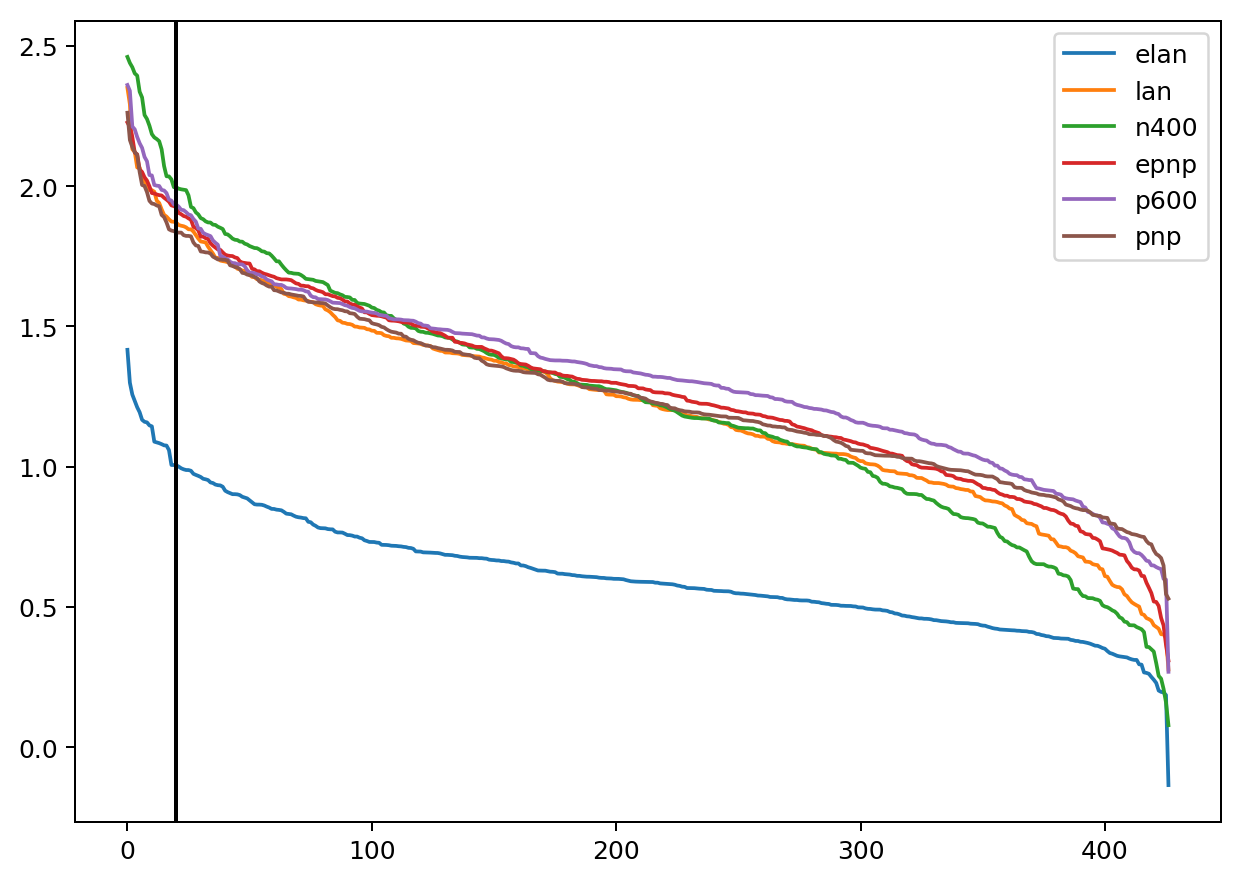

elan
Abby kneeled down to have another look in the tank that her mom had cleared so thoroughly, but Mr. Sticky was still nowhere to be found. [1.4165550470352173] sentential_co_ordination:1, object_relative_clause_non_restrictive:1
I then sat down on the floor and brushed away the hair that had accumulated on my shiny new Buster Brown shoes. [1.2993439435958862] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1
In response, the matron walked over to a little man sitting in an office chair that squeaked as it rolled around the floor and spoke to him. [1.257082462310791] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1, prepositional_phrase_attachment_ambiguity:1, gerund_modifier:1
Together they plunged into a mountain brook, which came foaming and dashing along, leaping over rocks and rushing down the hillside, until in the valley below they heard the strangest clattering noise. [1.2341972589492798] non_local_verb_phrase_conjuncti

In [53]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_erp_values, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')

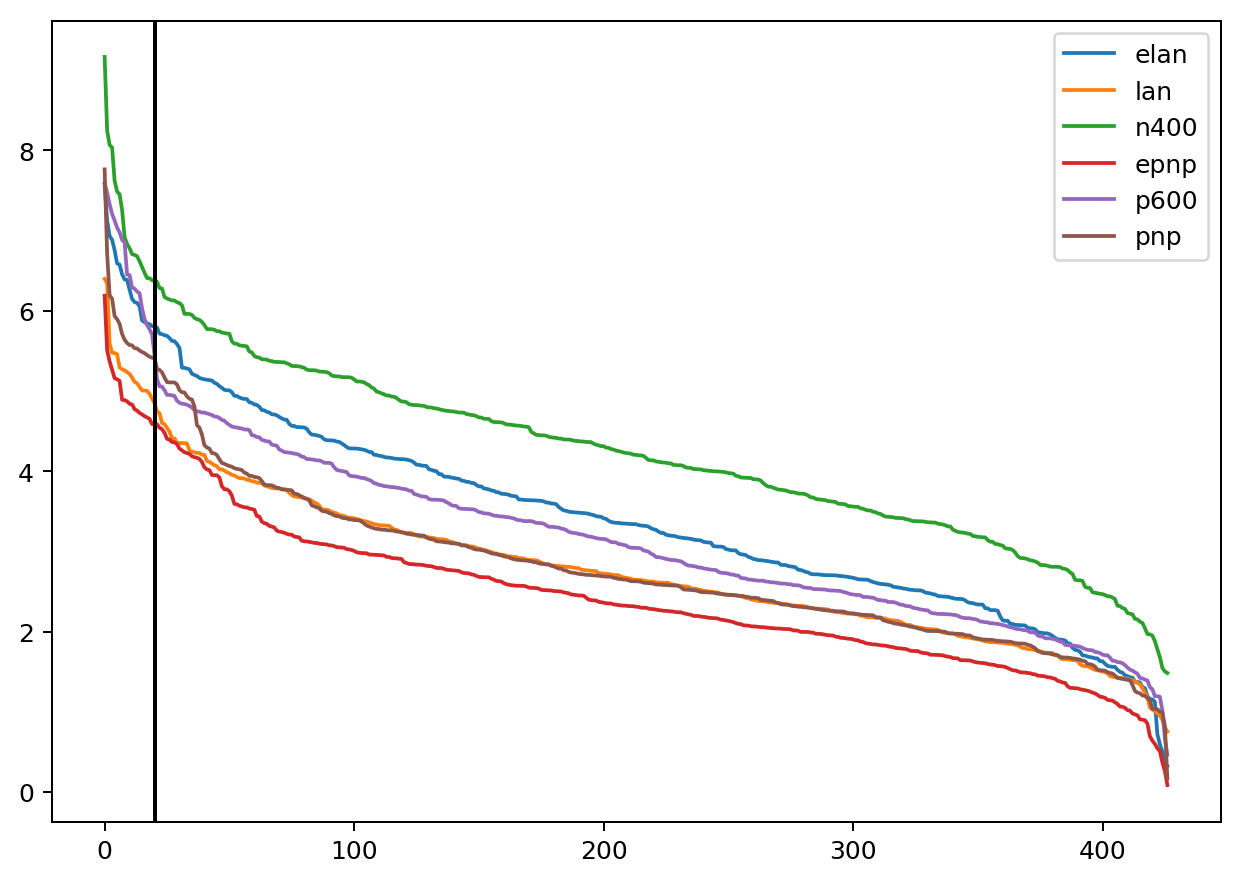

elan
That all mill owners were generally busy as beavers and quite pleased with themselves for being so successful and well off was known to the residents of Bradford, and if you were to go into the city to visit the stately City Hall, you would see there the Crest of the City of Bradford, which those same mill owners created to celebrate their achievements. [7.577284455299377] adjective_conjunction:2, object_relative_clause_non_restrictive:1, non_local_subject_verb:1, sentential_subject:1, if_then_construction:1, as_as_construction:1
Lucy did not know who it was that was sending her the messages, and she did not know how they had got her number, but whoever it was, he or she had slowly taken over Lucy's life. [7.12470243871212] sentential_co_ordination:1, complementizer_phrase_conjunctions:1, source_relative_clause_restrictive:1, object_relative_clause_restrictive:1, adverbial_relative_clause:1, free_relative_clause:3, it_cleft:1
The sun understood Aqua's request came from his heart, 

In [54]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_diff_erp, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')